# Hotel Booking Cancellations Prediction Model

<br><br>
<img src = 'https://www.gannett-cdn.com/presto/2019/05/02/USAT/5b1d7ecc-ce8d-43db-92b9-d7b61c198063-GettyImages-912299740.jpg?width=1320&height=880&fit=crop&format=pjpg&auto=webp'
     height = "600"
     width = "700"/>

<br><br>
<b>I. High Level Outline</b>

Here we are dealing with hotel booking cancellations for a large international hotel chain, and need to build a prediction model that shall help us predict such cancellations in order to take preventive measures to save on revenue loss.

<b> While we are using the available data to predict future cancellations, there are certain qualitative and situation-based reasons behind cancellations which are not easy to predict. It is important to note that the model cannot consider or accomodate for such aspects which lead to cancellation of hotel bookings.</b>

At present, we are looking at the following parameters which are important for our prediction:
- Lead time (how much in advance the booking has been made)
- Arrival date
- Days of stay (weekdays and weekends)
- Travellers types (number of adults, children and babies)
- Meal type
- Country of origin
- Market segment
- Distribution channel
- Repeated guest or not
- Previous cancellations
- Previous bookings not cancelled
- Room type
- Booking changes
- Deposit type
- Agent
- Company
- Days in waiting
- Customer type
- Average Daily Rate
- Required car parkings
- Special requests

<b>II. Brief Background</b>

1. What is the problem?<br>
Many hotels are facing the issue of last minute booking cacellation 
<br>
<br>
2. Why is it important?<br>
This prediction model is important for the hospitality industry which has seen a decline over the past couple of years, particularly with the Covid-19 pandemic.
Hotels have limited occupancy, and they lose out on potential revenue when they decline new customers on account of being fully booked, and then they see cancellations.
<br>
<br>
3. Who are the key stakeholders?<br>
This predictor model is beneficial for hotels and travel booking agencies.
<br>

<b>III. Cost of incorrect prediction</b>

1. False Positive<br>
In this case, model is predicting that booking will be cancelled but in reality it won't be cancelled<br>
If hotel management is sensing that booking is going to be cancelled then they might find new customer and if the booking is not cancelled eventually then management will have to deal with multiple customers with same room<br>
This can be dealt with easily by keeping the new customers on waitlist instead of directly assigning a room

2. False Negative<br>
In this case, model is predicting that booking will not be cancelled but in reality booking gets cancelled<br>
Here hotel loses potential revenue as the room will be unreserved as the booking get cancelled at the last moment<br>

- False Negatives are more costly for any hotel manegement so I would consider on reducing falls negatives by using recall as performance measure

# 1. Library Imports and Functions

In [1]:
import time

import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_colwidth', 0)
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import statsmodels.api as sm


from imblearn.over_sampling import SMOTE

from scipy import stats
from scipy.stats import norm
# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)

#SummaryStats function is used to find statastical tendancies of numerical columns in data. 
#Function prints mean, median, std_deviation, min value, max value, number of nulls, outliers from IQR and outliers from z score.
def summaryStats(X,feature_list):
    q1 = X[feature_list].quantile(0.25)
    q3 = X[feature_list].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    temp = pd.DataFrame(dict(mean = X[feature_list].mean().round(2),
                             median = X[feature_list].median().round(2),
                             std_dev = X[feature_list].std().round(2),
                             min_val = X[feature_list].min().round(2),
                             max_val = X[feature_list].max().round(2),
                             null_values = X[feature_list].isnull().sum(),
                             lower_bound = fence_low,
                             upper_bound = fence_high,
                             outliers_from_IQR = ((X[feature_list] < fence_low) | (X[feature_list] > fence_high)).sum(),
                             outliers_from_Zscore = (np.abs(stats.zscore(X[feature_list])) > 3).sum()
                            ))
    return temp

#This function assumes the input dataframe (X) has a numerically defined target
#Variable in the first column and that all remaining features are categorical
#This function helps to determine difference in target variable with changing categories in a features
def target_by_cats(X):
    global_mean = X.iloc[:,0].mean()
    target = X.columns[0]
    for col in X.columns[1:]:
        df_group = X.groupby(by=col)[target].agg(['mean','count']).round(2)
        df_group['diff'] = (df_group['mean'] - global_mean).round(2)
        df_group['%diff'] = (df_group['diff']/df_group['mean'])*100
        display(df_group)
        
# This function is used to consolidate the results of grid search of decision tree
def decision_tree_grid_search():
    max_depth = []
    min_impurity_decrease = []
    min_samples_split = []    
    df_output = pd.DataFrame()
    
    df_output['Accuracy'] = gridSearch.cv_results_.get('mean_test_accuracy')
    df_output['Recall'] = gridSearch.cv_results_.get('mean_test_recall')
    df_output['Precision'] = gridSearch.cv_results_.get('mean_test_precision')
    df_output['AUC'] = gridSearch.cv_results_.get('mean_test_roc_auc')
    
    for result in gridSearch.cv_results_.get('params'):
        max_depth.append(result.get('max_depth'))
        min_impurity_decrease.append(result.get('min_impurity_decrease'))
        min_samples_split.append(result.get('min_samples_split'))

    df_output['Max Depth'] = max_depth
    df_output['Minimum Impurity Decrease'] = min_impurity_decrease
    df_output['Minimum Samples Split'] = min_samples_split
    df_output['Model'] = 'Decision Tree'
    
    return df_output

# This function is used to plot the important features in decision tree
def plot_feature_importances(data,model):
    n_features = data.shape[1]
    fig = plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
def class_perf_measures(model,X_test,y_test, initial_th, final_th, interval):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    TP_per = []
    TN_per = []
    FP_per = []
    FN_per = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    auc = []
    
    # Create list of probability threshold values to loop over
    threshold = np.arange(initial_th,final_th + interval,interval).tolist()

    # Start loop
    for i in threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)
        # Append lists with metric values
        TP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,1]
        TN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,0]
        FP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,1]
        FN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,0]
        TP.append(TP_value)
        TN.append(TN_value)
        FP.append(FP_value)
        FN.append(FN_value)
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))
        TP_per.append(TP_value/(len(y_test)-1)*100)
        TN_per.append(TN_value/(len(y_test)-1)*100)
        FP_per.append(FP_value/(len(y_test)-1)*100)
        FN_per.append(FN_value/(len(y_test)-1)*100)
        auc.append(roc_auc_score(y_test, y_test_pred_class).round(3))

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "TP%": TP_per,
                           "TN%": TN_per,
                           "FP%": FP_per,
                           "FN%": FN_per,
                           "Precision":precision,
                           "Recall":recall,
                           "Accuracy": Accuracy,
                           "F1": F1,
                           "AUC": auc
                          })

    # Let's look at our dataframe
    return result

def is_model_tree_based(model):
    return ("Decision tree" in model) | ("Random Forest" in model)

def is_model_ANN(model):
    return "Neural Nets" in model

#This funtion is used to add the best performing model for each classifier into a dataframe so compare with other classifiers 
def update_results_df(model,y_test,y_pred,features_used,total_time,df_results,hyperparameters = np.nan):
    if(is_model_tree_based(model)):
        keys = ['ccp_alpha', 'max_depth', 'min_impurity_decrease', 'min_samples_split']
        hyperparameters = {x:hyperparameters[x] for x in keys}
    elif(is_model_ANN(model)):
        keys = ['activation', 'hidden_layer_sizes']
        hyperparameters = {x:hyperparameters[x] for x in keys}
    print(hyperparameters)
    results_dict = {"Model": model,
              "Accuracy": round(accuracy_score(y_test, y_pred),3),
              "Recall": round(recall_score(y_test, y_pred),3),
              "Precision": round(precision_score(y_test, y_pred),3),
              "AUC": round(roc_auc_score(y_test, y_pred),3),
              "Total time taken": total_time,
              "False Negative": confusion_matrix(y_test, y_pred)[1][0],
              "False Positive": confusion_matrix(y_test, y_pred)[0][1],
              "Features Used": features_used,
              "Hyperparameters": str(hyperparameters)}
    df_results = pd.concat([df_results, pd.DataFrame(results_dict,index=[0])], ignore_index=True)
    return df_results

def removeQuotations(countryCode):
    return countryCode[2:5]

# 2. Data Reading and initial Analysis

In [2]:
df = pd.read_csv("hotel_bookings.csv")
df.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0000,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,NaN,0,Transient,96.1400,0,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0000,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0000,NaN,0,Transient,225.4300,0,2
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0000,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0000,NaN,0,Transient,157.7100,0,4
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0000,NaN,0,Transient,104.4000,0,0
119389,City Hotel,0,205,2017,August,35,29,2,7,2,0.0000,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0000,NaN,0,Transient,151.2000,0,2


In [3]:
df.shape

(119390, 30)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

**Observation** 

- 119389 records of data so we can cut short the data as we want during data cleaning
- most of the column names are self explainatory. 
    - Market_segment, distribution channel: TA - travel agents, TO - tour Operators
    - agent: agent id
    - company: ID of the company/entity that made the booking or responsible for paying the booking
    - adr: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- Out of 30 features, 10 categorical, 18 numerical and 2 binary 
- is_cancelled is the target variable

|  Impact of features on target|    features                           |
|----------------------|---------------------------------------------------|
| High       | Hotel, stays_in_week_nights, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, assigned_room_type, deposit_type, days_in_waiting_list, country, booking_changes, adr|
| Low     | lead time, arrival_date_week_number, arrival_date_year, arrival_date_month, stays_in_weekend_nights, reserved_room_type, customer_type, children, babies, distribution_channel, total_of_special_requests|
| No impact          | arrival_date_day_of_month, meal, adults, market_segment, agent, company, required_car_parking_spaces|

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0000,0.3704,0.4829,0.0000,0.0000,0.0000,1.0000,1.0000
lead_time,119390.0000,104.0114,106.8631,0.0000,18.0000,69.0000,160.0000,737.0000
arrival_date_year,119390.0000,2016.1566,0.7075,2015.0000,2016.0000,2016.0000,2017.0000,2017.0000
arrival_date_week_number,119390.0000,27.1652,13.6051,1.0000,16.0000,28.0000,38.0000,53.0000
arrival_date_day_of_month,119390.0000,15.7982,8.7808,1.0000,8.0000,16.0000,23.0000,31.0000
stays_in_weekend_nights,119390.0000,0.9276,0.9986,0.0000,0.0000,1.0000,2.0000,19.0000
stays_in_week_nights,119390.0000,2.5003,1.9083,0.0000,1.0000,2.0000,3.0000,50.0000
adults,119390.0000,1.8564,0.5793,0.0000,2.0000,2.0000,2.0000,55.0000
children,119386.0000,0.1039,0.3986,0.0000,0.0000,0.0000,0.0000,10.0000
babies,119390.0000,0.0079,0.0974,0.0000,0.0000,0.0000,0.0000,10.0000


# 3. Treating with dups,nulls and outliers

In [7]:
print("Records before dropping dups", len(df))
df.drop_duplicates(inplace=True,ignore_index=True)
print("Records after dropping dups", len(df))

Records before dropping dups 119390
Records after dropping dups 87138


We have dropped around 30,000 duplicate records

In [8]:
df_numerical = df.select_dtypes(include=['int64','float64'])
#lets drop is_repeted guest as it is binary column
df_numerical.drop(columns=['is_repeated_guest'], inplace=True)

In [9]:
summaryStats(df_numerical,df_numerical.columns)

,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
is_canceled,0.2700,0.0000,0.4500,0.0000,1.0000,0,-1.5000,2.5000,0,0
lead_time,79.7200,49.0000,85.9400,0.0000,737.0000,0,-160.0000,296.0000,2371,1062
arrival_date_year,2016.2100,2016.0000,0.6900,2015.0000,2017.0000,0,2014.5000,2018.5000,0,0
arrival_date_week_number,26.8400,27.0000,13.6700,1.0000,53.0000,0,-15.5000,68.5000,0,0
arrival_date_day_of_month,15.8100,16.0000,8.8400,1.0000,31.0000,0,-14.5000,45.5000,0,0
stays_in_weekend_nights,1.0100,1.0000,1.0300,0.0000,19.0000,0,-3.0000,5.0000,218,287
stays_in_week_nights,2.6300,2.0000,2.0500,0.0000,50.0000,0,-3.5000,8.5000,1524,1524
adults,1.8800,2.0000,0.6300,0.0000,55.0000,0,2.0000,2.0000,22825,76
children,0.1400,0.0000,0.4600,0.0000,10.0000,4,0.0000,0.0000,8352,0
babies,0.0100,0.0000,0.1100,0.0000,10.0000,0,0.0000,0.0000,914,914


**Observations**

- nulls present in agent and company 
- It might be because the booking was done individually 
- Check how many records have both agent and company

In [10]:
df_numerical[~np.isnan(df_numerical['agent']) & ~np.isnan(df_numerical['company'])]

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2207,0,6,2015,42,11,2,0,2,0.0000,0,0,0,1,240.0000,113.0000,0,82.0000,1,1
2441,0,24,2015,44,26,7,15,1,0.0000,0,0,0,2,185.0000,281.0000,0,52.2000,0,0
2579,0,24,2015,45,3,0,3,2,0.0000,0,0,0,1,334.0000,281.0000,0,48.0000,0,0
2589,0,24,2015,45,3,2,10,1,0.0000,0,0,0,2,328.0000,281.0000,0,40.0000,0,0
2590,0,24,2015,45,3,3,10,2,0.0000,0,0,0,2,326.0000,281.0000,0,48.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81388,0,13,2017,21,24,0,1,2,0.0000,0,0,0,0,9.0000,478.0000,0,150.0000,0,1
81829,0,13,2017,22,29,1,3,1,0.0000,0,0,0,1,290.0000,148.0000,0,95.0000,0,0
81862,0,13,2017,22,29,1,3,2,0.0000,0,0,0,1,290.0000,148.0000,0,110.0000,0,0
82321,0,210,2017,23,9,0,1,2,0.0000,0,0,0,0,14.0000,229.0000,0,135.0000,0,0


**Observations** 

- Only 188 records have both agent and company. Which means for 188 records, company is making booking through travel agents.
- for remaining records booking is done either by agent or company or individual person 
- we can create 4 column: is_booked_individually, is_booked_by_company, is_booked_by_agent, is_booked_by_comoany_through_agent
- replace the nulls in agent by 0
- drop the company column as it comtains 81890 nulls out of 87k datapoints
- there are 4 records with Nan for children, we can replace it by 0 as it is the meadin number of children

In [11]:
#adding the binary columns in main df only as this df is for numerical variables
df['booked_by'] = np.where((np.isnan(df['agent'])) & (np.isnan(df['company'])),'Individually',(np.where((~(np.isnan(df['agent']))) & (np.isnan(df['company'])),'Agent',(np.where((np.isnan(df['agent'])) & (~(np.isnan(df['company']))),'Company','Company through Agent')))))

df_numerical.drop(columns=['company'], inplace=True)
df_numerical['agent'].fillna(0.00, inplace=True)
df_numerical['children'].fillna(0.00, inplace=True)

df.drop(columns=['company'], inplace=True)
df['agent'].fillna(0.00, inplace=True)
df['children'].fillna(0.00, inplace=True)

In [12]:
summaryStats(df_numerical,df_numerical.columns)

,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
is_canceled,0.2700,0.0000,0.4500,0.0000,1.0000,0,-1.5000,2.5000,0,0
lead_time,79.7200,49.0000,85.9400,0.0000,737.0000,0,-160.0000,296.0000,2371,1062
arrival_date_year,2016.2100,2016.0000,0.6900,2015.0000,2017.0000,0,2014.5000,2018.5000,0,0
arrival_date_week_number,26.8400,27.0000,13.6700,1.0000,53.0000,0,-15.5000,68.5000,0,0
arrival_date_day_of_month,15.8100,16.0000,8.8400,1.0000,31.0000,0,-14.5000,45.5000,0,0
stays_in_weekend_nights,1.0100,1.0000,1.0300,0.0000,19.0000,0,-3.0000,5.0000,218,287
stays_in_week_nights,2.6300,2.0000,2.0500,0.0000,50.0000,0,-3.5000,8.5000,1524,1524
adults,1.8800,2.0000,0.6300,0.0000,55.0000,0,2.0000,2.0000,22825,76
children,0.1400,0.0000,0.4600,0.0000,10.0000,0,0.0000,0.0000,8352,3664
babies,0.0100,0.0000,0.1100,0.0000,10.0000,0,0.0000,0.0000,914,914


**Observation**

- Now we have delt with nulls, lets see the outliers
- From summery stats, we can see many columns have potential outliers 
- we will consider z score to call a data point outlier. It is an outlier if it lies beyond 3sigma

In [13]:
df_numerical.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

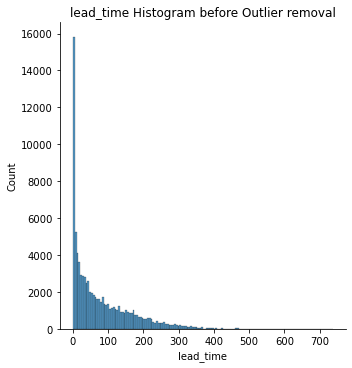

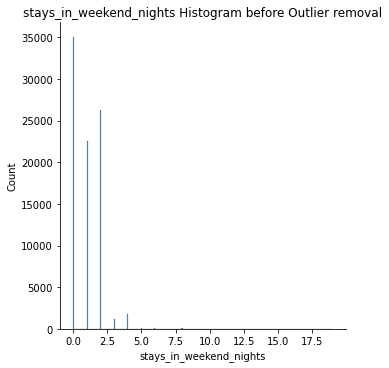

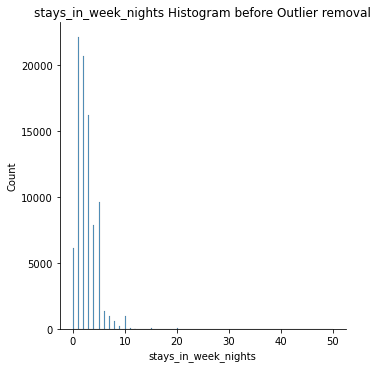

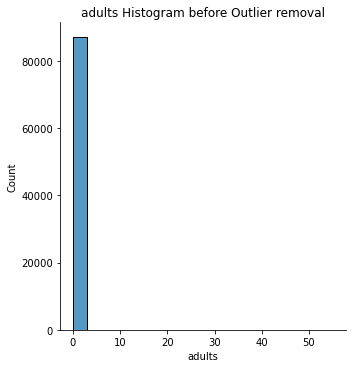

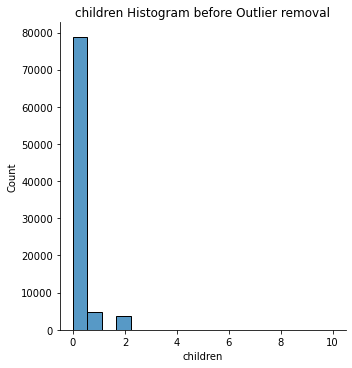

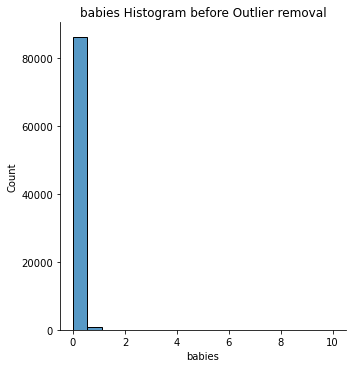

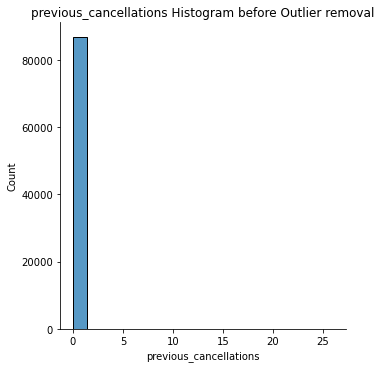

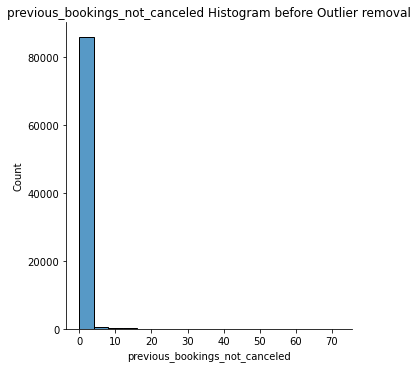

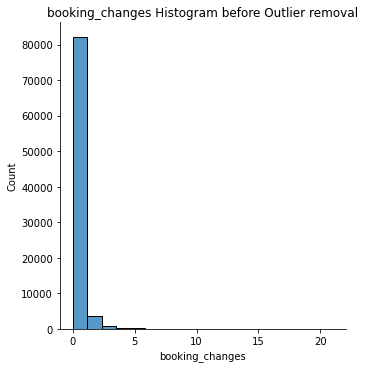

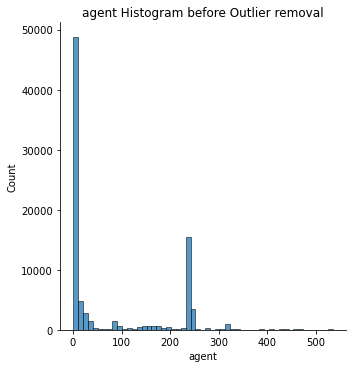

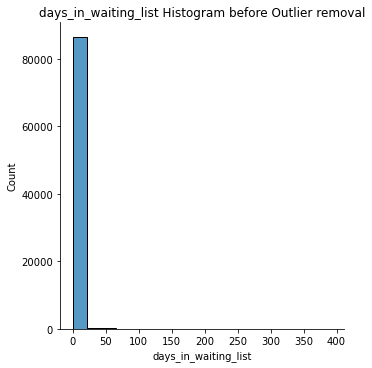

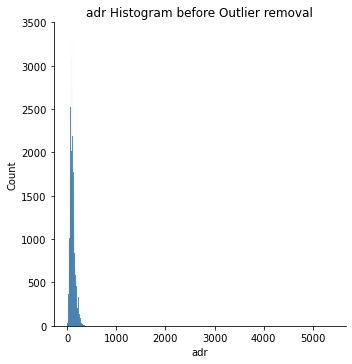

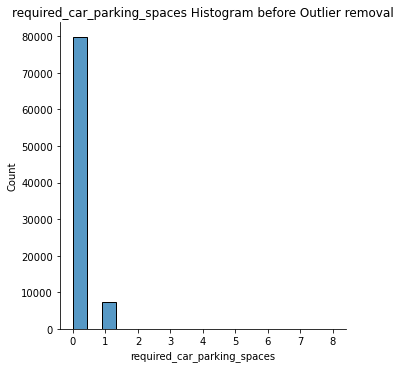

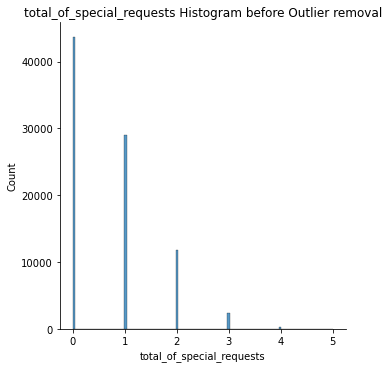

In [14]:
graph_columns= ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests']

for i, col in enumerate(graph_columns):
    plt.figure(i)
    sns.displot(df[col])
    plt.title(col + ' Histogram before Outlier removal')  

**Observation**
- Looking at the histogram of lead time we can see the normlization is required for lead time,  will use log transform for the normalization
- as we cant take log of 0, lets convert 0 to 1 for lead time
- We will remove other outliers using z score. If the absolute z score is more than 3 then we consider the point as outlier and remove it

In [15]:
df_numerical['lead_time'] = np.where(df_numerical['lead_time'] == 0, 1, df_numerical['lead_time'])
df_numerical['lead_time'] = np.log(df_numerical['lead_time'])

df['lead_time'] = np.where(df['lead_time'] == 0, 1, df['lead_time'])
df['lead_time'] = np.log(df['lead_time'])


In [16]:
df_numerical

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,5.8348,2015,27,1,0,0,2,0.0000,0,0,0,3,0.0000,0,0.0000,0,0
1,0,6.6026,2015,27,1,0,0,2,0.0000,0,0,0,4,0.0000,0,0.0000,0,0
2,0,1.9459,2015,27,1,0,1,1,0.0000,0,0,0,0,0.0000,0,75.0000,0,0
3,0,2.5649,2015,27,1,0,1,1,0.0000,0,0,0,0,304.0000,0,75.0000,0,0
4,0,2.6391,2015,27,1,0,2,2,0.0000,0,0,0,0,240.0000,0,98.0000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87133,0,3.1355,2017,35,30,2,5,2,0.0000,0,0,0,0,394.0000,0,96.1400,0,0
87134,0,4.6250,2017,35,31,2,5,3,0.0000,0,0,0,0,9.0000,0,225.4300,0,2
87135,0,3.5264,2017,35,31,2,5,2,0.0000,0,0,0,0,9.0000,0,157.7100,0,4
87136,0,4.6913,2017,35,31,2,5,2,0.0000,0,0,0,0,89.0000,0,104.4000,0,0


<AxesSubplot:xlabel='lead_time', ylabel='Count'>

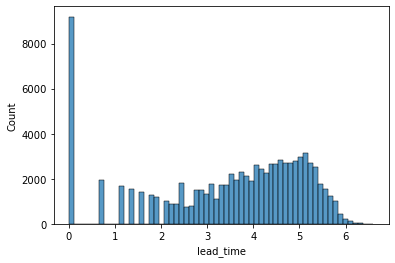

In [17]:
sns.histplot(df_numerical['lead_time'])

In [18]:
print("Number of records before dropping outlier", len(df_numerical))
df = df[(np.abs(stats.zscore(df_numerical)) < 3).all(axis=1)].reset_index(drop=True)
df_numerical = df_numerical[(np.abs(stats.zscore(df_numerical)) < 3).all(axis=1)].reset_index(drop=True)
print("Number of records after dropping outlier", len(df_numerical))


Number of records before dropping outlier 87138
Number of records after dropping outlier 71031


# 4. Feature Selection 

In [19]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,booked_by
0,Resort Hotel,0,1.9459,2015,July,27,1,0,1,1,0.0000,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0000,0,Transient,75.0000,0,0,Individually
1,Resort Hotel,0,2.5649,2015,July,27,1,0,1,1,0.0000,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0000,0,Transient,75.0000,0,0,Agent
2,Resort Hotel,0,2.6391,2015,July,27,1,0,2,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0000,0,Transient,98.0000,0,1,Agent
3,Resort Hotel,0,0.0000,2015,July,27,1,0,2,2,0.0000,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0.0000,0,Transient,107.0000,0,0,Individually
4,Resort Hotel,0,2.1972,2015,July,27,1,0,2,2,0.0000,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0000,0,Transient,103.0000,0,1,Agent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,0,3.0445,2017,August,35,30,2,5,2,0.0000,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,0,2,Agent
71027,City Hotel,0,3.1355,2017,August,35,30,2,5,2,0.0000,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,0,0,Agent
71028,City Hotel,0,4.6250,2017,August,35,31,2,5,3,0.0000,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0000,0,Transient,225.4300,0,2,Agent
71029,City Hotel,0,4.6913,2017,August,35,31,2,5,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0000,0,Transient,104.4000,0,0,Agent


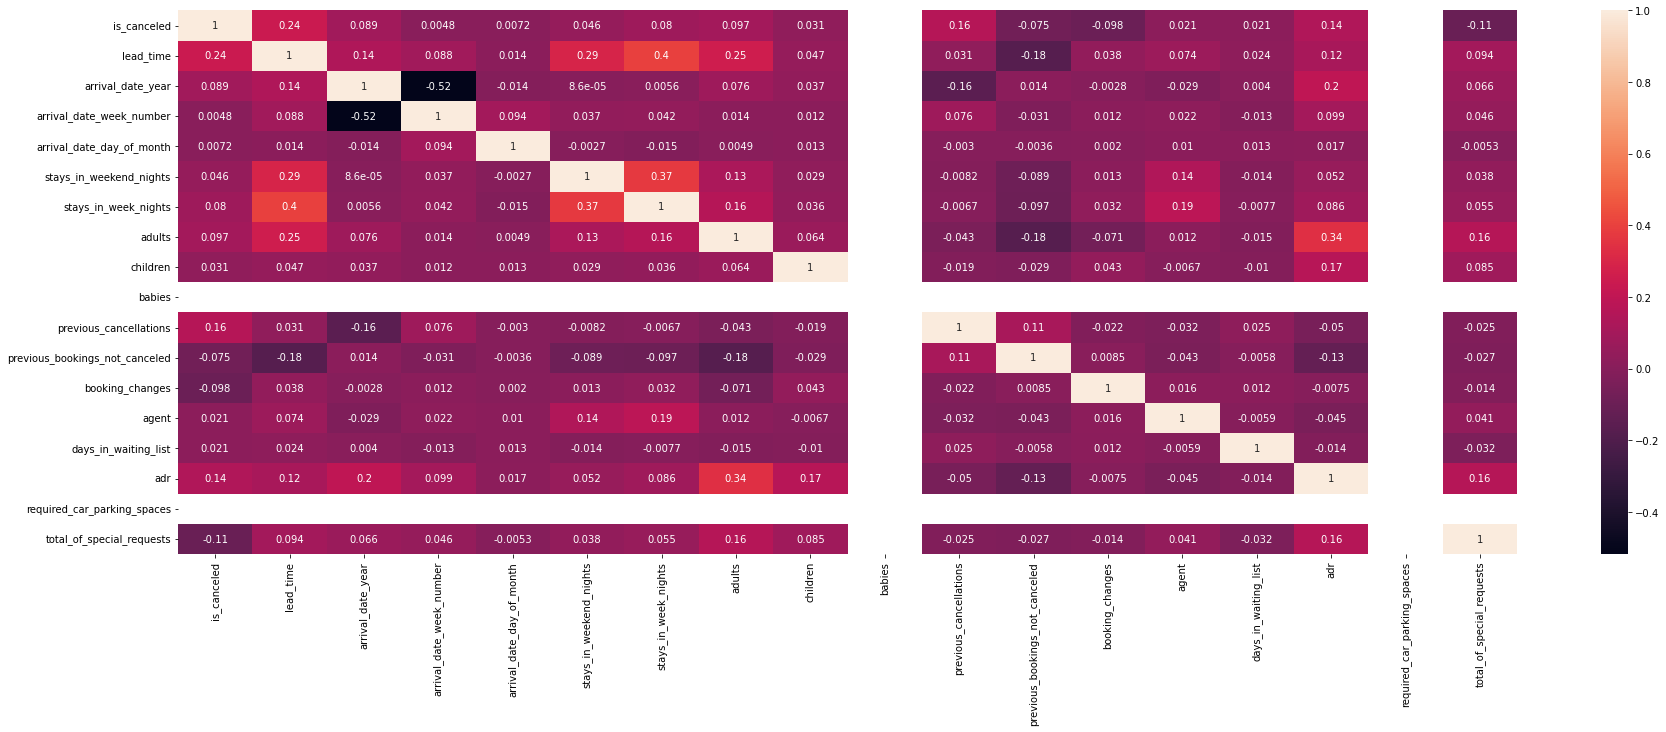

In [20]:
plt.figure(figsize=(30,10))
sns.heatmap(df_numerical.corr(), annot=True)
plt.show()

- lead time shows slight correlation with booking cancelation other features dont show significant relation 
- lets plot scatter plots to understand it better

In [21]:
df['babies'].unique()

array([0], dtype=int64)

In [22]:
df['required_car_parking_spaces'].unique()

array([0], dtype=int64)

- as there is only one unique value for babies and required car parking spaces, we can delete these column

In [23]:
df_numerical.drop(columns=['babies','required_car_parking_spaces'],inplace=True)
df.drop(columns=['babies','required_car_parking_spaces'],inplace=True)

In [24]:
# Categorical Variables
df_categorical = df.select_dtypes(include=['object'])
df_categorical

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,booked_by
0,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Individually
1,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Agent
2,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent
3,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Individually
4,Resort Hotel,July,FB,PRT,Direct,Direct,C,C,No Deposit,Transient,Agent
...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent
71027,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent
71028,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Agent
71029,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent


In [25]:
# Now i will add the 2 binary column to this df and one categorical 
df_categorical.insert(loc=0, column='is_canceled',value=df['is_canceled'])
df_categorical['is_repeated_guest'] = df['is_repeated_guest']

In [26]:
df_categorical

,is_canceled,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,booked_by,is_repeated_guest
0,0,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Individually,0
1,0,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Agent,0
2,0,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0
3,0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Individually,0
4,0,Resort Hotel,July,FB,PRT,Direct,Direct,C,C,No Deposit,Transient,Agent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,0,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0
71027,0,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0
71028,0,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Agent,0
71029,0,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0


In [27]:
target_by_cats(df_categorical)

,mean,count,diff,%diff
hotel,,,,
City Hotel,0.3100,46858,0.0200,6.4516
Resort Hotel,0.2700,24173,-0.0200,-7.4074


,mean,count,diff,%diff
arrival_date_month,,,,
April,0.3300,6449,0.0400,12.1212
August,0.3500,8796,0.0600,17.1429
December,0.2900,4061,-0.0000,-0.0000
February,0.2500,5068,-0.0400,-16.0000
January,0.2400,3735,-0.0500,-20.8333
July,0.3500,7952,0.0600,17.1429
June,0.3200,6284,0.0300,9.3750
March,0.2600,6365,-0.0300,-11.5385
May,0.3100,6924,0.0200,6.4516


,mean,count,diff,%diff
meal,,,,
BB,0.2800,55007,-0.0100,-3.5714
FB,0.3100,232,0.0200,6.4516
HB,0.3000,6570,0.0100,3.3333
SC,0.3600,8947,0.0700,19.4444
Undefined,0.1900,275,-0.1000,-52.6316


,mean,count,diff,%diff
country,,,,
ABW,0.0000,2,-0.2900,-inf
AGO,0.4500,196,0.1600,35.5556
ALB,0.2000,10,-0.0900,-45.0000
AND,1.0000,4,0.7100,71.0000
ARE,0.8600,35,0.5700,66.2791
...,...,...,...,...
VGB,1.0000,1,0.7100,71.0000
VNM,0.2500,8,-0.0400,-16.0000
ZAF,0.3500,65,0.0600,17.1429


,mean,count,diff,%diff
market_segment,,,,
Aviation,0.2000,196,-0.0900,-45.0000
Complementary,0.1600,477,-0.1300,-81.2500
Corporate,0.1400,3007,-0.1500,-107.1429
Direct,0.1700,8488,-0.1200,-70.5882
Groups,0.2800,3919,-0.0100,-3.5714
Offline TA/TO,0.1500,11740,-0.1400,-93.3333
Online TA,0.3700,43202,0.0800,21.6216
Undefined,1.0000,2,0.7100,71.0000


,mean,count,diff,%diff
distribution_channel,,,,
Corporate,0.1400,3660,-0.1500,-107.1429
Direct,0.1700,9344,-0.1200,-70.5882
GDS,0.1800,176,-0.1100,-61.1111
TA/TO,0.3200,57847,0.0300,9.3750
Undefined,1.0000,4,0.7100,71.0000


,mean,count,diff,%diff
reserved_room_type,,,,
A,0.2800,48962,-0.0100,-3.5714
B,0.3000,647,0.0100,3.3333
C,0.3100,226,0.0200,6.4516
D,0.3300,14970,0.0400,12.1212
E,0.3400,4368,0.0500,14.7059
F,0.2400,1035,-0.0500,-20.8333
G,0.2800,532,-0.0100,-3.5714
H,0.5700,281,0.2800,49.1228
L,0.4000,5,0.1100,27.5000


,mean,count,diff,%diff
assigned_room_type,,,,
A,0.3200,40768,0.0300,9.3750
B,0.1900,1379,-0.1000,-52.6316
C,0.1400,1153,-0.1500,-107.1429
D,0.2700,19103,-0.0200,-7.4074
E,0.2800,5351,-0.0100,-3.5714
F,0.1700,1657,-0.1200,-70.5882
G,0.2000,798,-0.0900,-45.0000
H,0.4700,356,0.1800,38.2979
I,0.0200,243,-0.2700,-1350.0000


,mean,count,diff,%diff
deposit_type,,,,
No Deposit,0.2900,70113,-0.0000,-0.0000
Non Refund,0.9500,845,0.6600,69.4737
Refundable,0.2900,73,-0.0000,-0.0000


,mean,count,diff,%diff
customer_type,,,,
Contract,0.1800,2518,-0.1100,-61.1111
Group,0.0800,421,-0.2100,-262.5000
Transient,0.3200,58740,0.0300,9.3750
Transient-Party,0.1600,9352,-0.1300,-81.2500


,mean,count,diff,%diff
booked_by,,,,
Agent,0.3200,62015,0.0300,9.3750
Company,0.1300,3633,-0.1600,-123.0769
Company through Agent,0.1000,125,-0.1900,-190.0000
Individually,0.1600,5258,-0.1300,-81.2500


,mean,count,diff,%diff
is_repeated_guest,,,,
0,0.3000,68939,0.0100,3.3333
1,0.0900,2092,-0.2000,-222.2222


**Observations**
- Hotel: cancellation % doesnd change much with the hotel type
- Month: April, may, june, july, august have more than 30% booking of cancellation 
- Meal: BB, FB, HB constitute to majority of meals and there is very less change in %cancellation in these type of meals
- 172 countries we can bucket this column according to continent or ignore the column. For now i willignore it
- market_segemt: There is significcant difference in % with marcket segment
- distribution_channel: here also % changes with distribution channel
- reserved room type: We might want to bucket it and keep top 4 and classify remainings as 'other'. % is not chaging that much with reserved room type.
- assigned room type: Again we might want to bucket it but % is not changing much
- deposit type: even though almost all the records are for no deposit, non refundable records are being cancelled 95% of the time which is very big number
- customer type: % is changing
- booked_by: % is changing considerably
- is_repeated guest: if gueast is repeated then he/she cancel the booking only for 9% of the times

**Conclusion**
- Categorical variables to consider: 'Market_segment','deposit_type','customer_type','booked_by','is_repeated_guest'

**Tasks**
- Create a column is_room_changed which specifies if assigned room is not same as reserved room 
- Reduce the unique values in reserved room type and assigned room type column by keeping the top few recordsand merging the remaining records in 'other' category
- Bucket the countries by continent to reduce the number of unique values
- Convert the text month column into month number 

In [28]:
df_categorical['is_room_changed'] = np.where((df_categorical['reserved_room_type'] == df_categorical['assigned_room_type']),0,1)
df['is_room_changed'] = np.where((df_categorical['reserved_room_type'] == df_categorical['assigned_room_type']),0,1)   

In [29]:
#top_5_countries = df_categorical.groupby('country')['is_canceled'].count().sort_values(ascending=False).head(5)
top_3_reserved_room_types = df_categorical.groupby('reserved_room_type')['is_canceled'].count().sort_values(ascending=False).head(3)
top_3_assigned_room_types = df_categorical.groupby('assigned_room_type')['is_canceled'].count().sort_values(ascending=False).head(3)

In [30]:
#df.loc[~(df_categorical['country'].isin(top_5_countries.index)),'country'] = 'Other'
df.loc[~(df_categorical['reserved_room_type'].isin(top_3_reserved_room_types.index)),'reserved_room_type'] = 'Other'
df.loc[~(df_categorical['assigned_room_type'].isin(top_3_assigned_room_types.index)),'assigned_room_type'] = 'Other'

#df_categorical.loc[~(df_categorical['country'].isin(top_5_countries.index)),'country'] = 'Other'
df_categorical.loc[~(df_categorical['reserved_room_type'].isin(top_3_reserved_room_types.index)),'reserved_room_type'] = 'Other'
df_categorical.loc[~(df_categorical['assigned_room_type'].isin(top_3_assigned_room_types.index)),'assigned_room_type'] = 'Other'

In [31]:
df_country_code= pd.read_csv('countries_codes_and_coordinates.csv',encoding = "ISO-8859-1")
df_continent = pd.read_csv("Countries-Continents.csv")

df_country_code = df_country_code.join(df_continent.set_index('Country'), on='Country', how='inner')

df_country_code["Alpha-3 code"] = df_country_code["Alpha-3 code"].apply(lambda x: removeQuotations(x))

df = df.join(df_country_code.set_index("Alpha-3 code")['Continent'],on='country',how='left')

df.loc[df['country'] == "USA", "Continent"] = "North America"
df.loc[df['country'] == "CZE", "Continent"] = "Europe"
df.loc[df['country'] == "KOR", "Continent"] = "Asia"
df.loc[df['country'] == "IRN", "Continent"] = "Asia"
df.loc[df['country'] == "TWN", "Continent"] = "Asia"
df.loc[df['country'] == "HKG", "Continent"] = "Asia"
df.loc[df['country'] == "CN", "Continent"] = "Asia"

df = df.dropna()
df = df.drop('country',axis=1)
df_categorical['Continent'] = df['Continent']
df_categorical = df_categorical.drop('country',axis=1)

- We can drop these 374 rows

In [32]:
df['assigned_room_type'].unique()

array(['Other', 'A', 'D', 'E'], dtype=object)

In [33]:
target_by_cats(df_categorical)

,mean,count,diff,%diff
hotel,,,,
City Hotel,0.3100,46858,0.0200,6.4516
Resort Hotel,0.2700,24173,-0.0200,-7.4074


,mean,count,diff,%diff
arrival_date_month,,,,
April,0.3300,6449,0.0400,12.1212
August,0.3500,8796,0.0600,17.1429
December,0.2900,4061,-0.0000,-0.0000
February,0.2500,5068,-0.0400,-16.0000
January,0.2400,3735,-0.0500,-20.8333
July,0.3500,7952,0.0600,17.1429
June,0.3200,6284,0.0300,9.3750
March,0.2600,6365,-0.0300,-11.5385
May,0.3100,6924,0.0200,6.4516


,mean,count,diff,%diff
meal,,,,
BB,0.2800,55007,-0.0100,-3.5714
FB,0.3100,232,0.0200,6.4516
HB,0.3000,6570,0.0100,3.3333
SC,0.3600,8947,0.0700,19.4444
Undefined,0.1900,275,-0.1000,-52.6316


,mean,count,diff,%diff
market_segment,,,,
Aviation,0.2000,196,-0.0900,-45.0000
Complementary,0.1600,477,-0.1300,-81.2500
Corporate,0.1400,3007,-0.1500,-107.1429
Direct,0.1700,8488,-0.1200,-70.5882
Groups,0.2800,3919,-0.0100,-3.5714
Offline TA/TO,0.1500,11740,-0.1400,-93.3333
Online TA,0.3700,43202,0.0800,21.6216
Undefined,1.0000,2,0.7100,71.0000


,mean,count,diff,%diff
distribution_channel,,,,
Corporate,0.1400,3660,-0.1500,-107.1429
Direct,0.1700,9344,-0.1200,-70.5882
GDS,0.1800,176,-0.1100,-61.1111
TA/TO,0.3200,57847,0.0300,9.3750
Undefined,1.0000,4,0.7100,71.0000


,mean,count,diff,%diff
reserved_room_type,,,,
A,0.2800,48962,-0.0100,-3.5714
D,0.3300,14970,0.0400,12.1212
E,0.3400,4368,0.0500,14.7059
Other,0.3000,2731,0.0100,3.3333


,mean,count,diff,%diff
assigned_room_type,,,,
A,0.3200,40768,0.0300,9.3750
D,0.2700,19103,-0.0200,-7.4074
E,0.2800,5351,-0.0100,-3.5714
Other,0.1800,5809,-0.1100,-61.1111


,mean,count,diff,%diff
deposit_type,,,,
No Deposit,0.2900,70113,-0.0000,-0.0000
Non Refund,0.9500,845,0.6600,69.4737
Refundable,0.2900,73,-0.0000,-0.0000


,mean,count,diff,%diff
customer_type,,,,
Contract,0.1800,2518,-0.1100,-61.1111
Group,0.0800,421,-0.2100,-262.5000
Transient,0.3200,58740,0.0300,9.3750
Transient-Party,0.1600,9352,-0.1300,-81.2500


,mean,count,diff,%diff
booked_by,,,,
Agent,0.3200,62015,0.0300,9.3750
Company,0.1300,3633,-0.1600,-123.0769
Company through Agent,0.1000,125,-0.1900,-190.0000
Individually,0.1600,5258,-0.1300,-81.2500


,mean,count,diff,%diff
is_repeated_guest,,,,
0,0.3000,68939,0.0100,3.3333
1,0.0900,2092,-0.2000,-222.2222


,mean,count,diff,%diff
is_room_changed,,,,
0,0.3300,60750,0.0400,12.1212
1,0.0500,10281,-0.2400,-480.0000


,mean,count,diff,%diff
Continent,,,,
Africa,0.4000,726,0.1100,27.5000
Asia,0.3600,3504,0.0700,19.4444
Europe,0.2900,62352,-0.0000,-0.0000
North America,0.2400,1652,-0.0500,-20.8333
Oceania,0.2400,386,-0.0500,-20.8333
South America,0.3700,2037,0.0800,21.6216


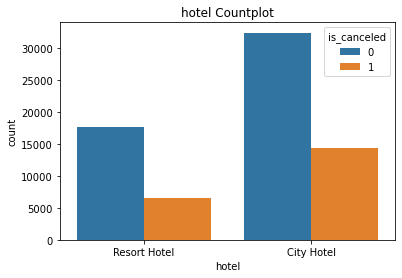

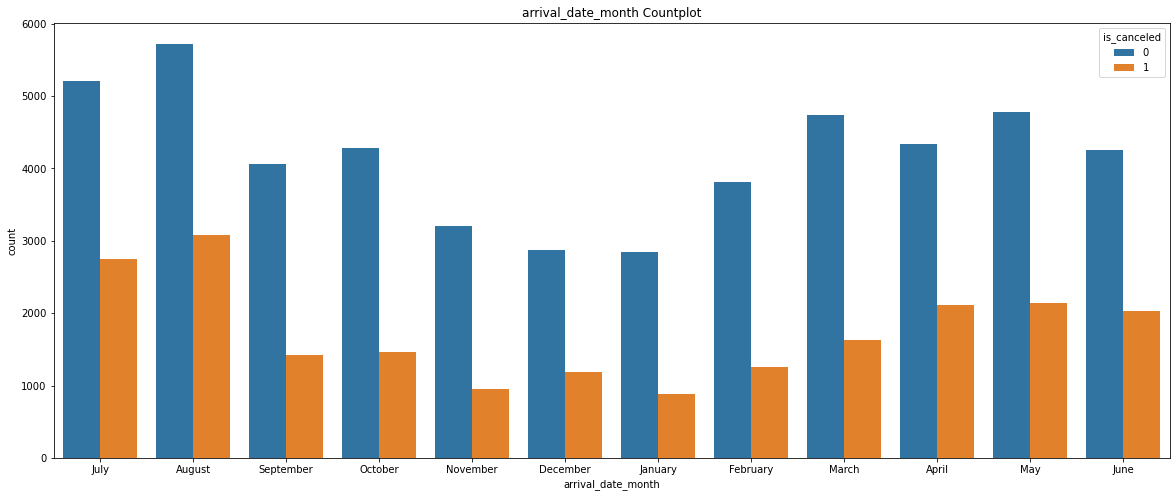

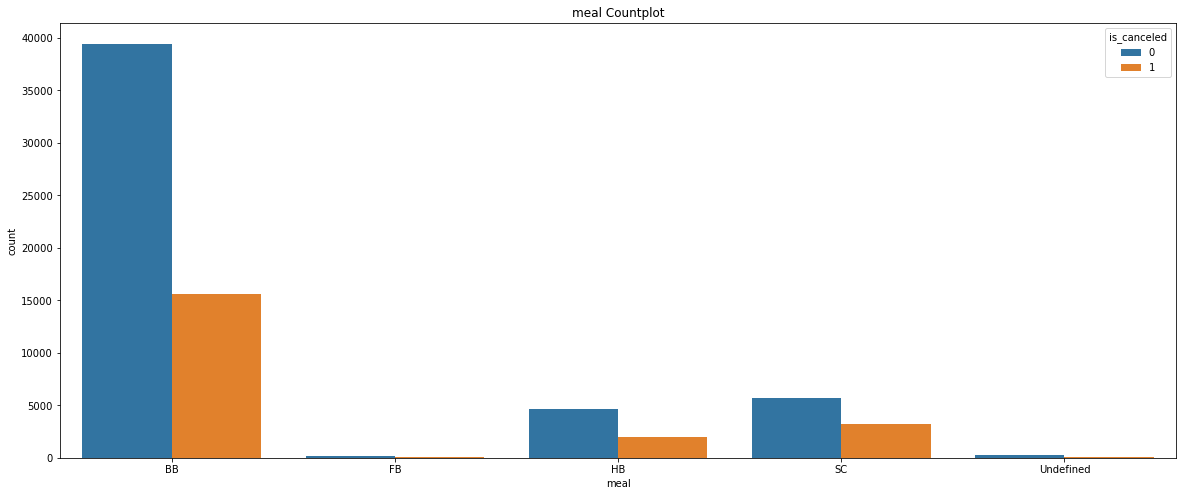

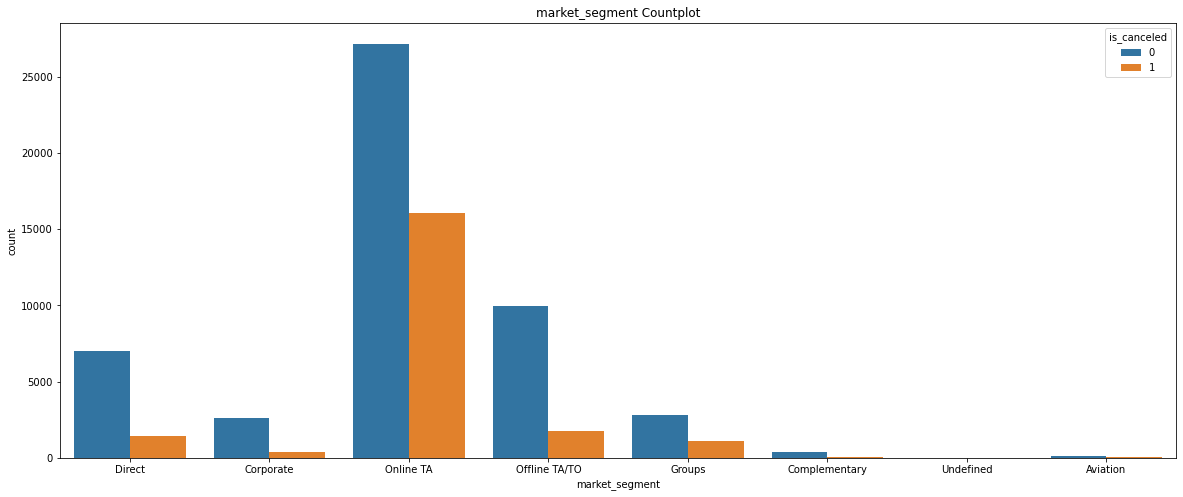

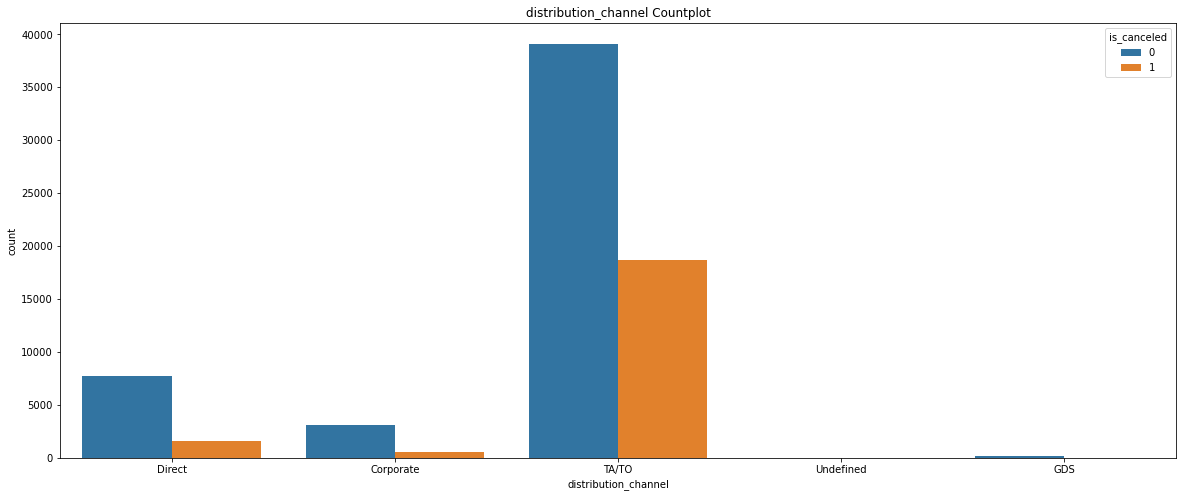

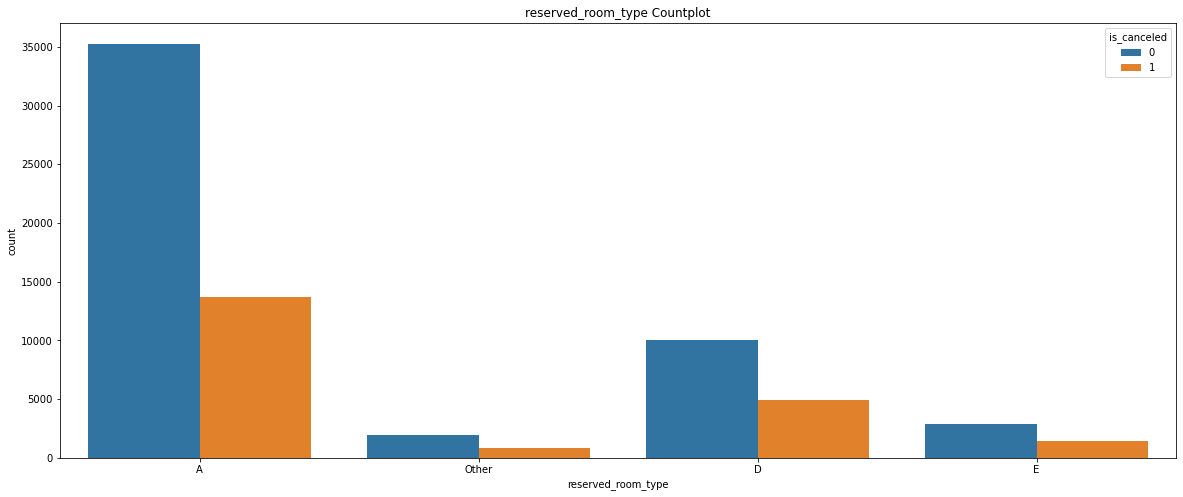

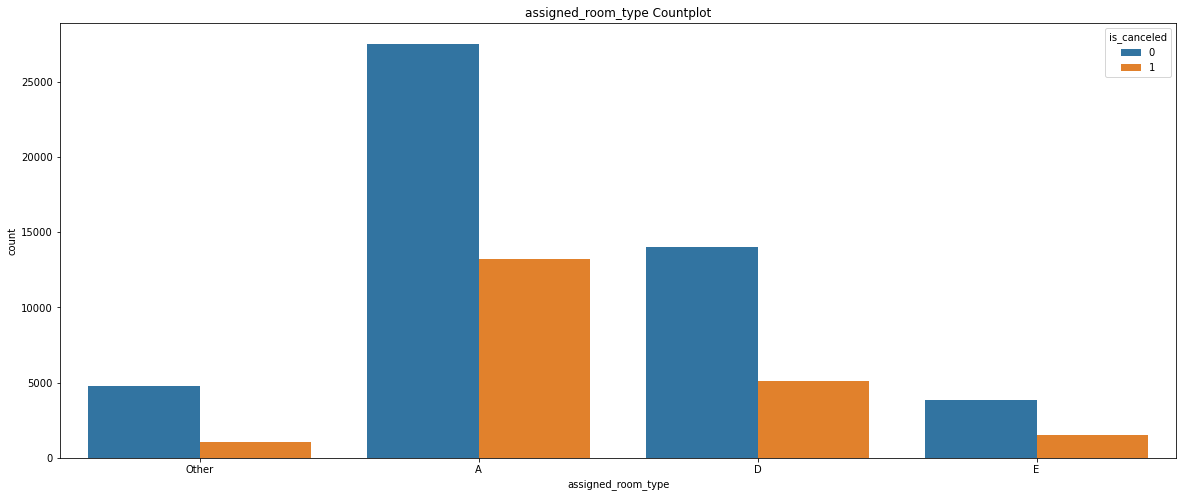

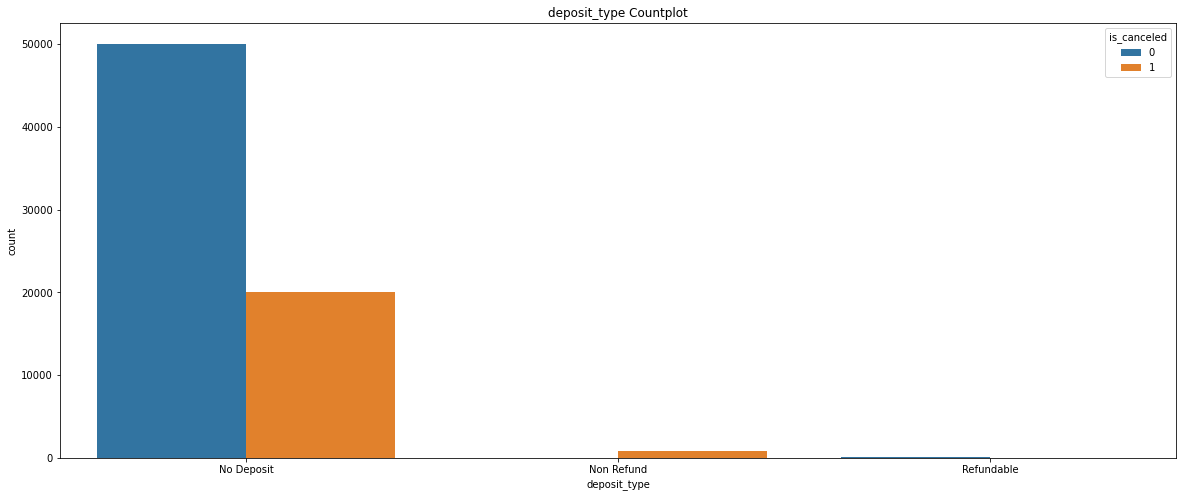

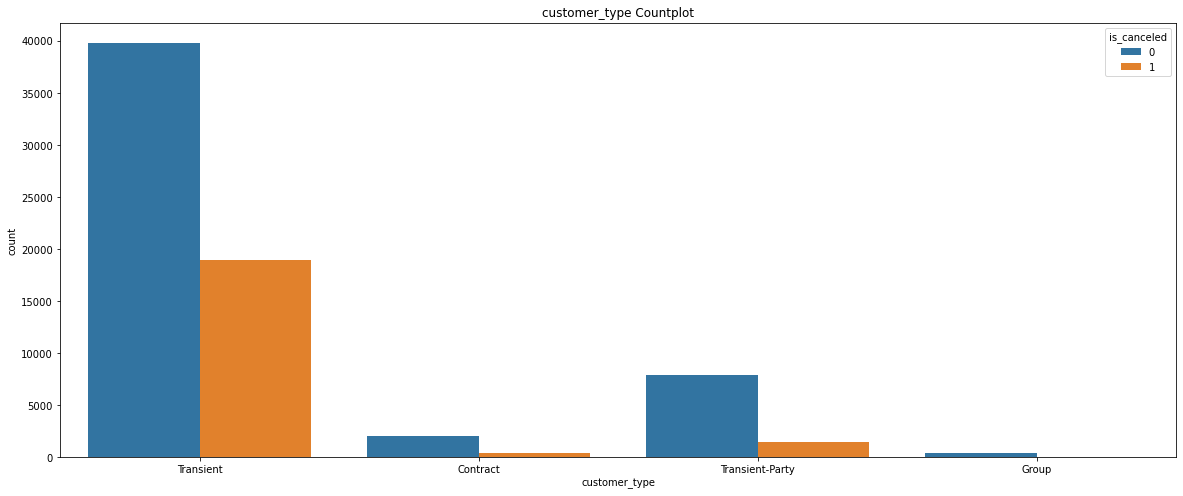

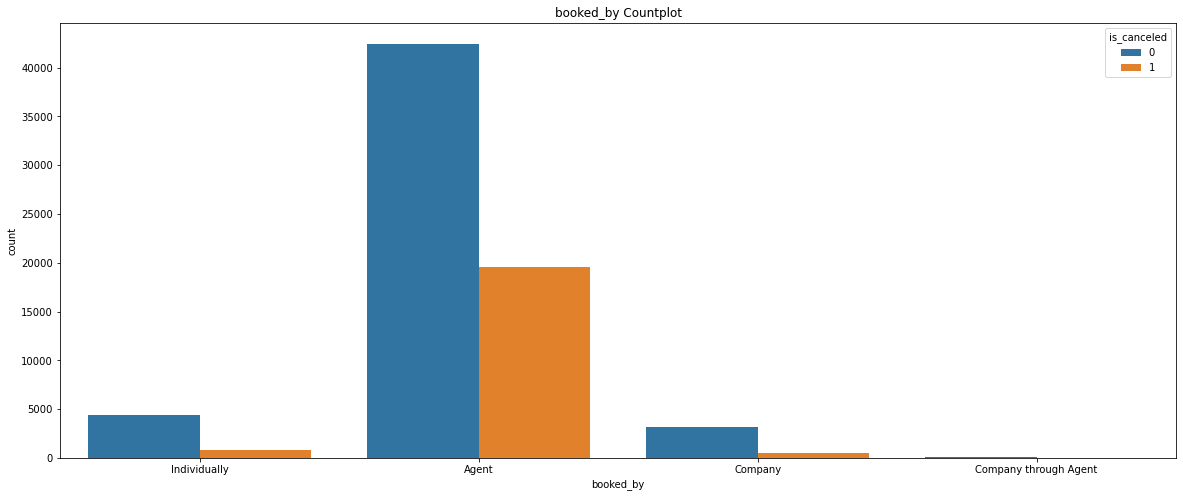

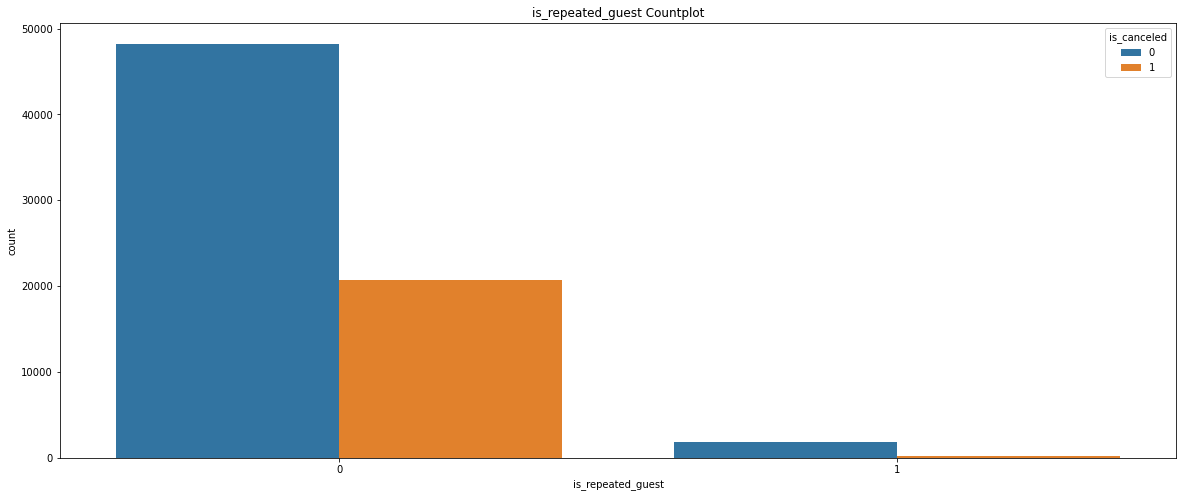

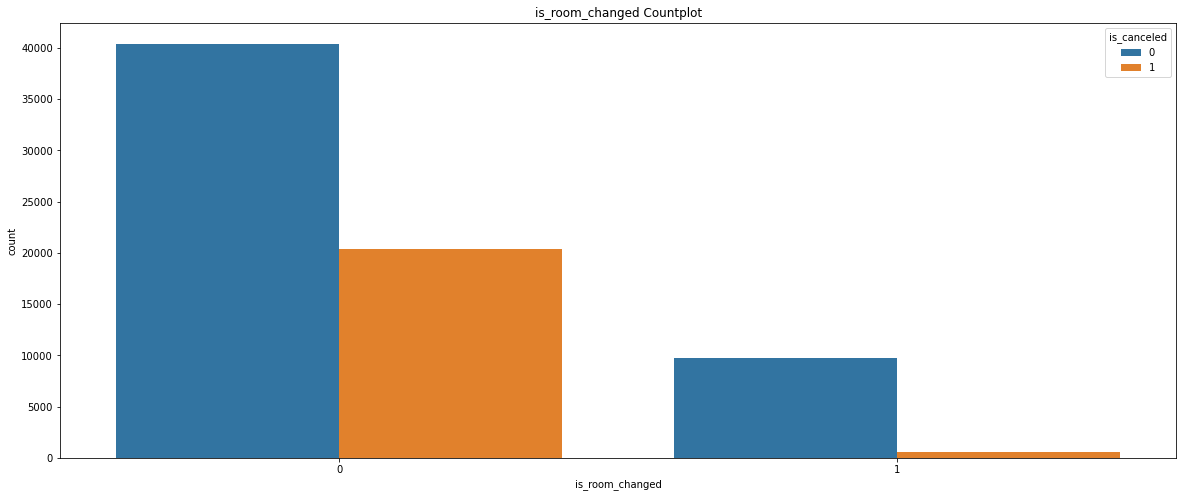

<Figure size 1440x576 with 0 Axes>

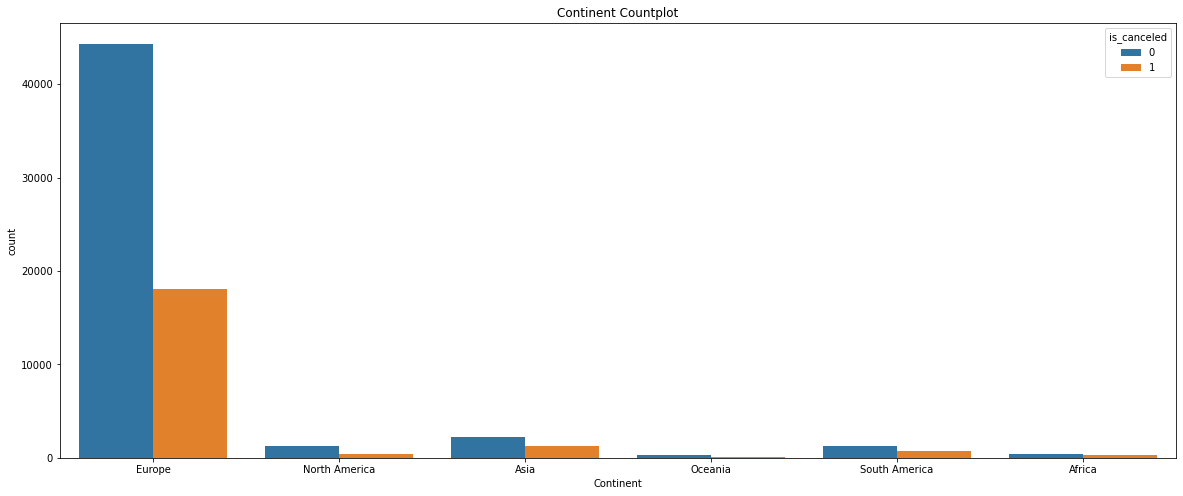

In [34]:
categorical_columns = df_categorical.loc[:, df_categorical.columns != 'is_canceled']

for i, col in enumerate(categorical_columns):
    f = plt.figure(figsize=(20,8))
    plt.figure(i)
    sns.countplot(data=df_categorical, x = df_categorical[col], hue=df_categorical['is_canceled'])
    plt.title(col + ' Countplot') 

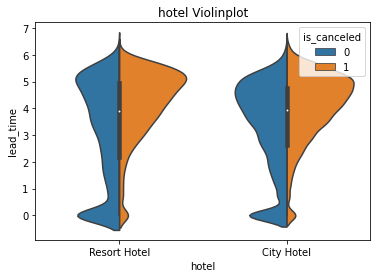

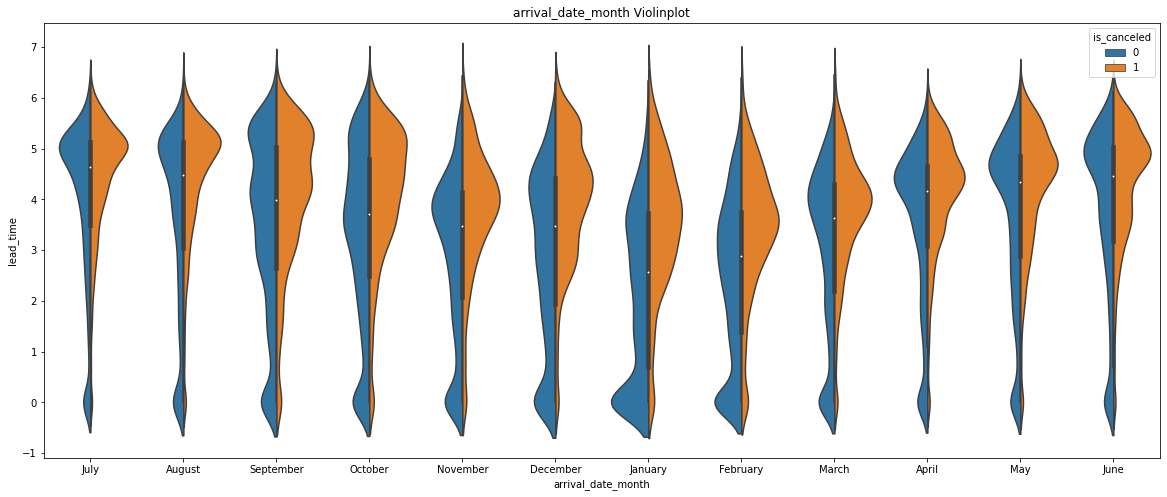

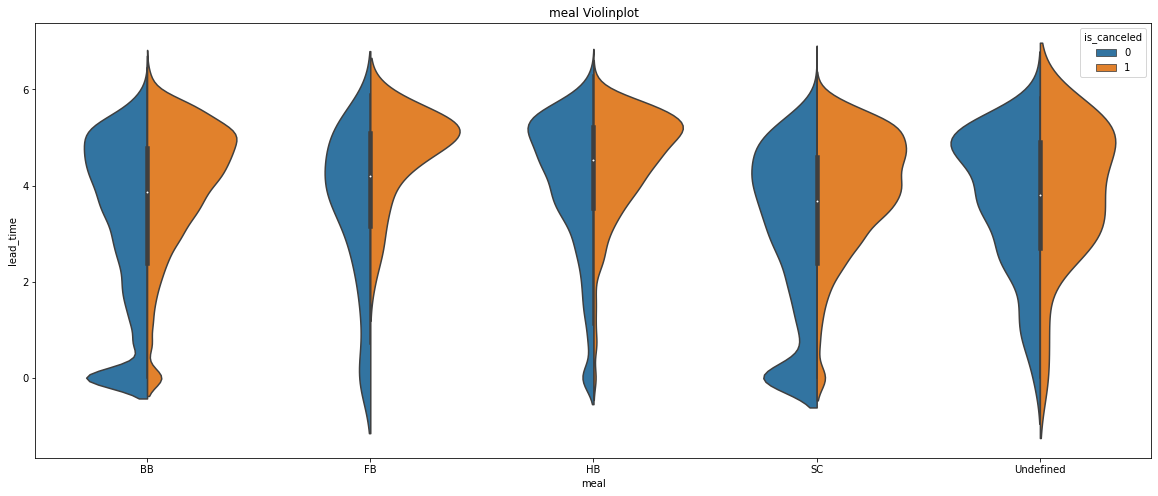

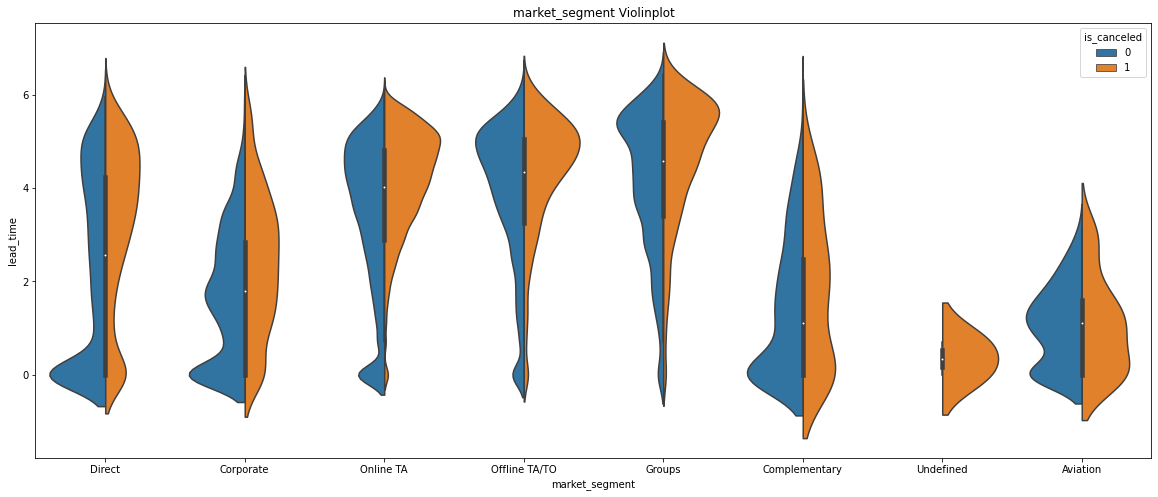

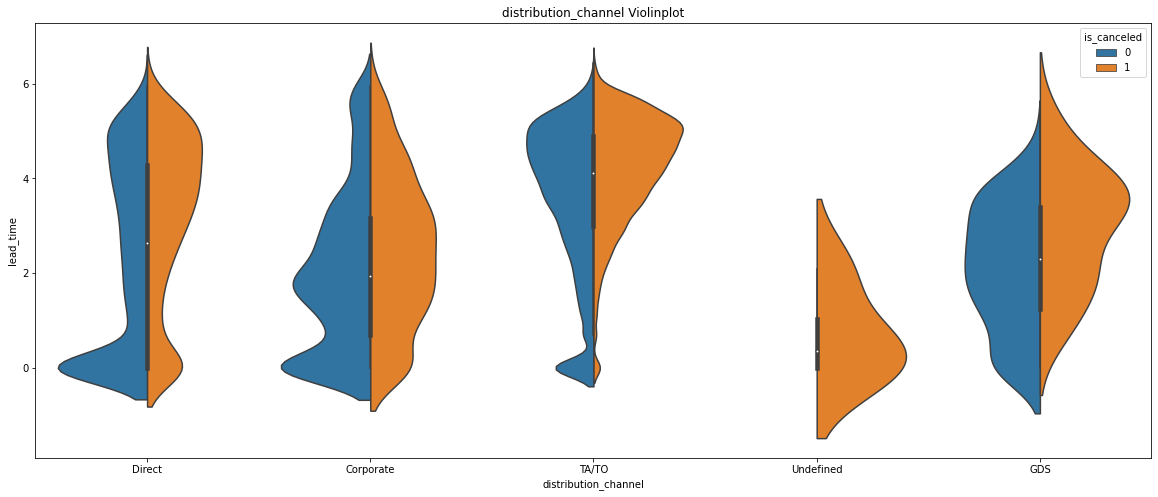

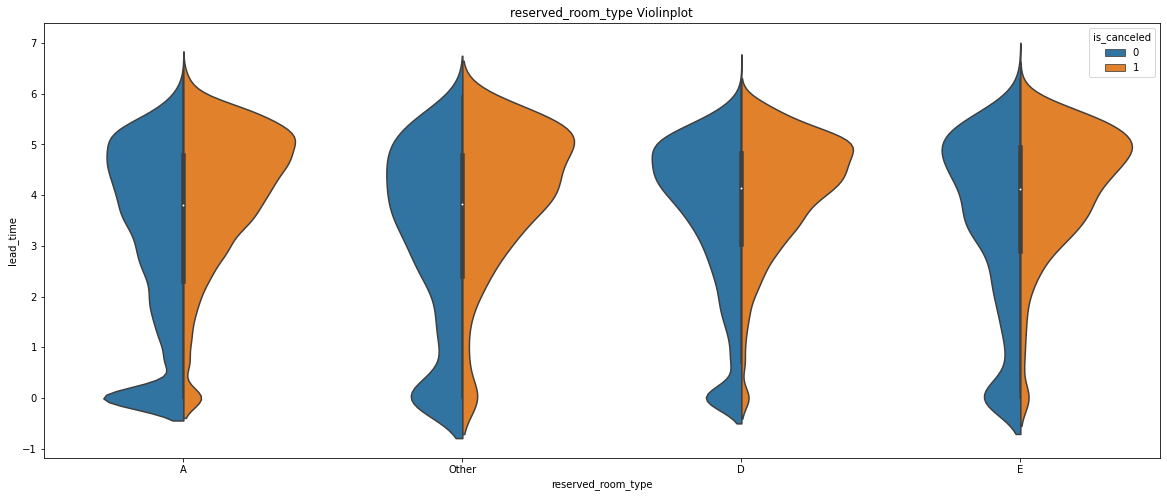

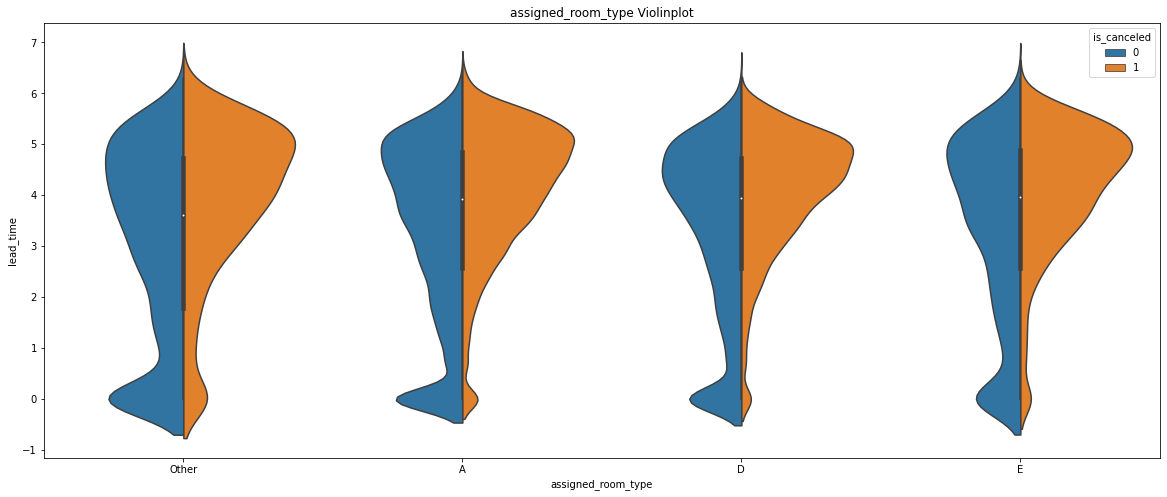

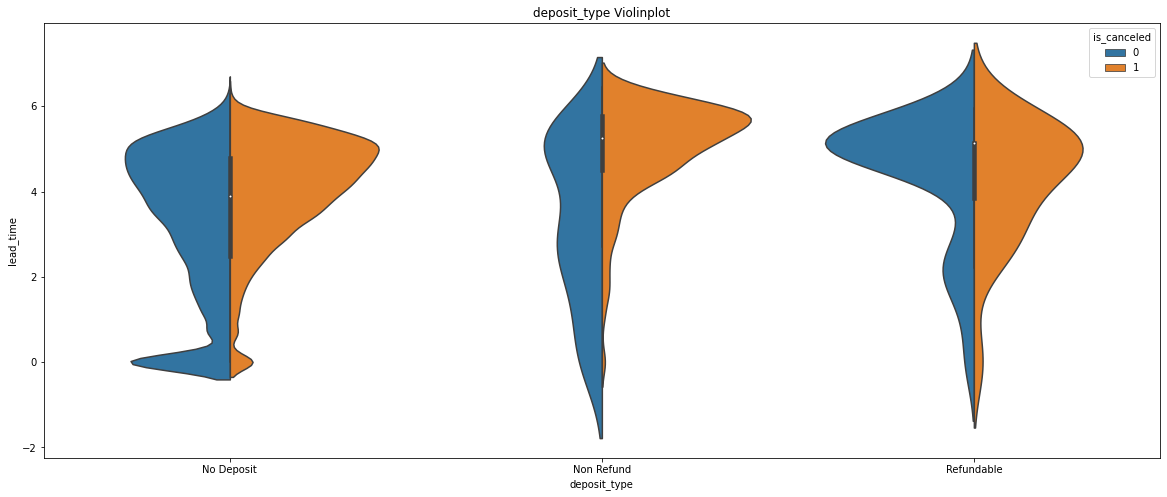

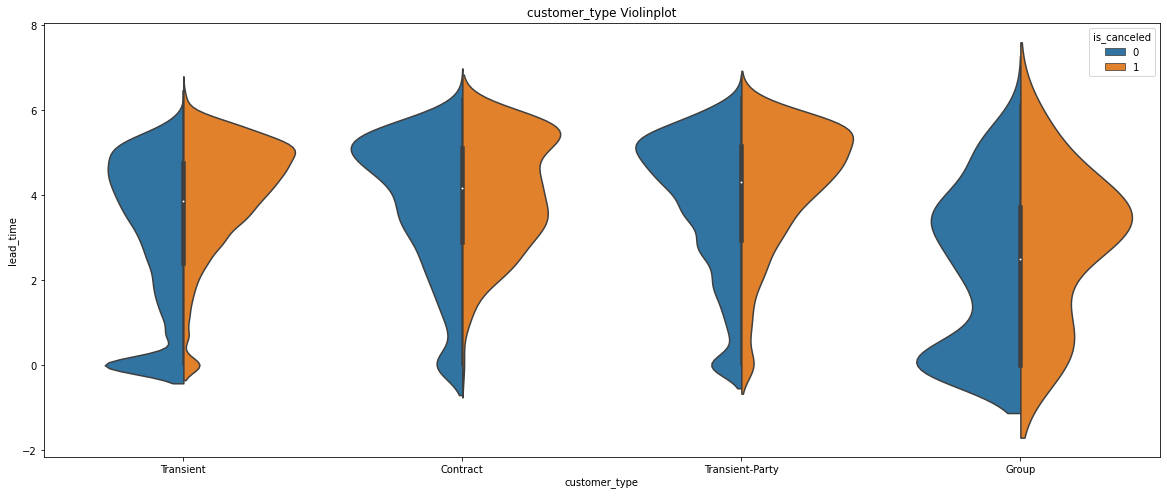

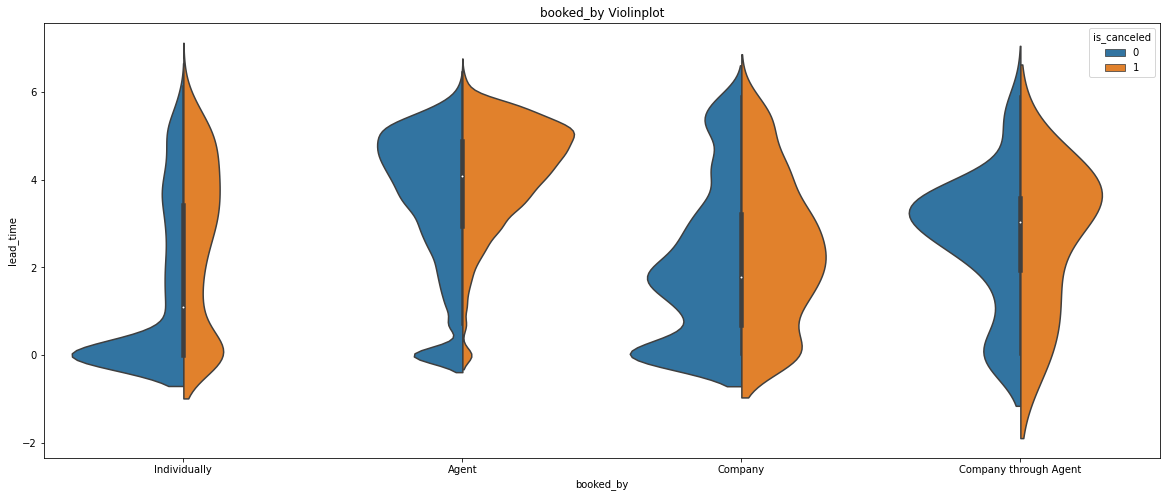

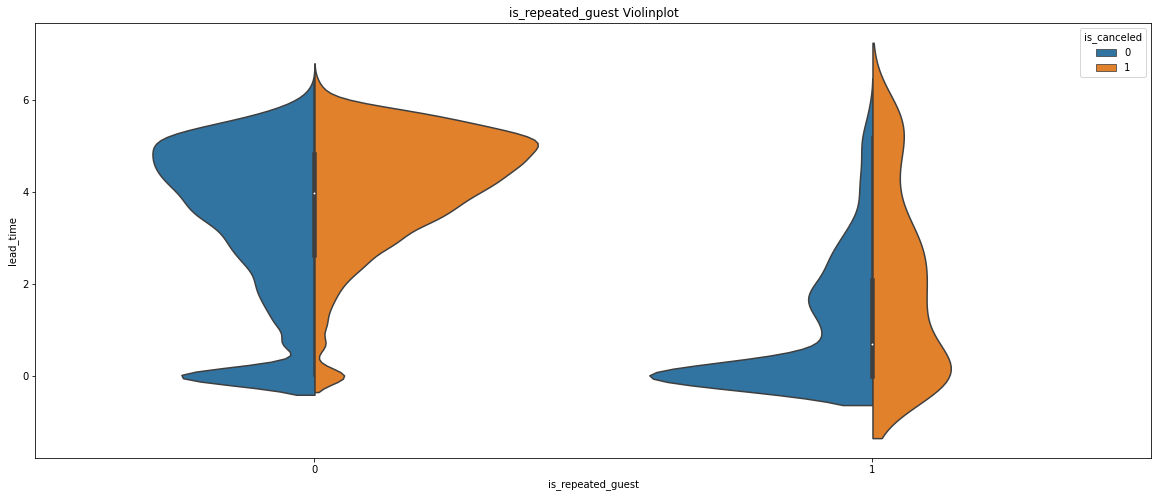

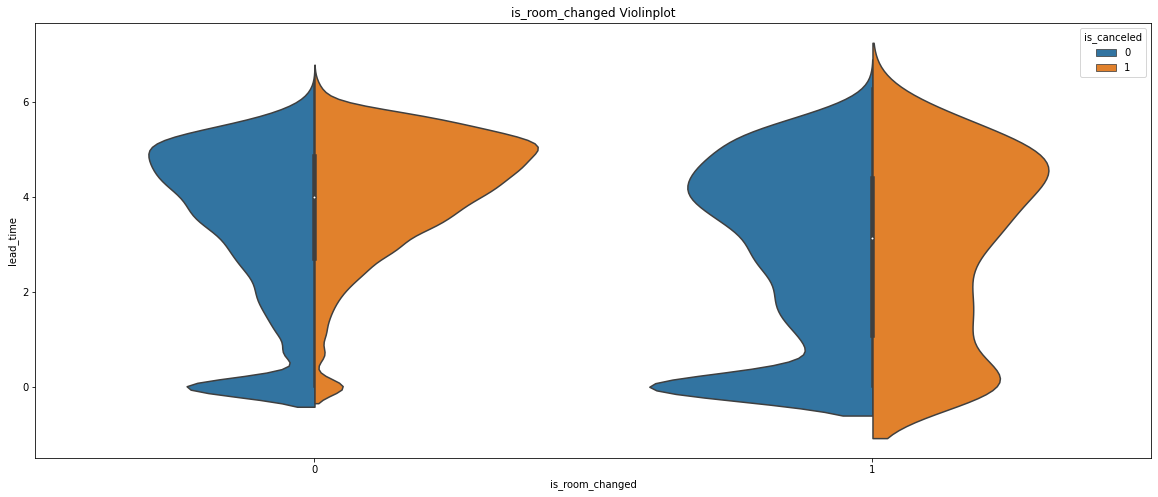

<Figure size 1440x576 with 0 Axes>

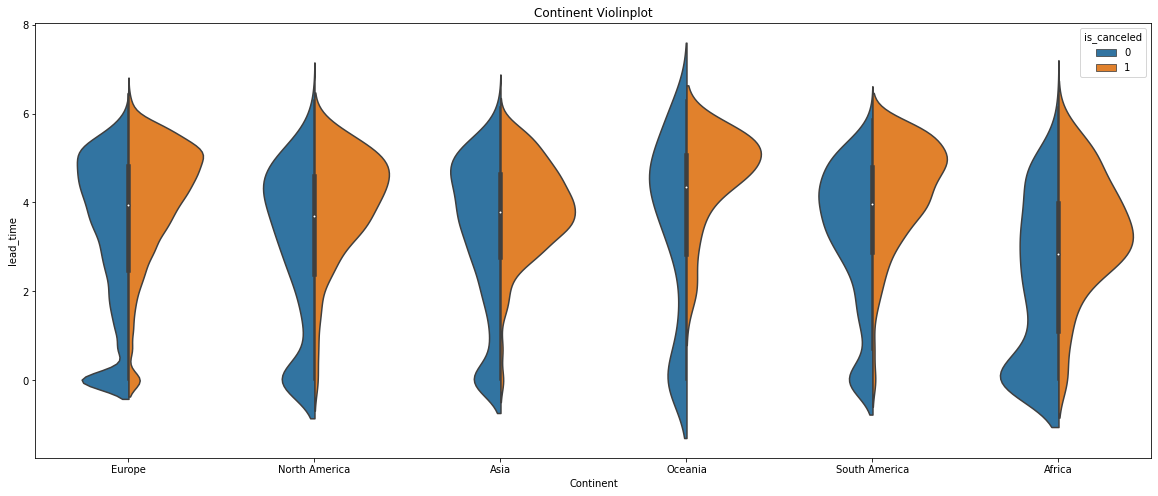

In [35]:
for i, col in enumerate(categorical_columns):
    f = plt.figure(figsize=(20,8))
    plt.figure(i)
    sns.violinplot(data=df, x = col, y='lead_time', hue=df_categorical['is_canceled'], split=True)
    plt.title(col + ' Violinplot') 

In [36]:
month_map = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}
df.arrival_date_month = df.arrival_date_month.map(month_map).astype(int)

In [37]:
df_small = df[['is_canceled','lead_time','previous_cancellations','adr','total_of_special_requests','market_segment','deposit_type','customer_type','booked_by','is_room_changed','agent','booking_changes','arrival_date_week_number','arrival_date_year','Continent']]

- For modeling, I will be using all the features present as well as only the features that I have selected and then I will try to compair performace in both of them. The features I have selected are stored in the param.

In [38]:
param = ['lead_time', 'previous_cancellations', 'adr',
       'total_of_special_requests', 'is_room_changed', 'agent',
       'booking_changes', 'arrival_date_week_number', 'arrival_date_year',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Undefined',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'booked_by_Agent', 'booked_by_Company',
       'booked_by_Company through Agent', 'booked_by_Individually',
       'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
       'Continent_North America', 'Continent_Oceania',
       'Continent_South America']

# 5. Encoding categorical variables, Data splitting, Normlizing

In [39]:
#Convering categorical to binary
df = pd.get_dummies(df, prefix_sep='_', drop_first=False)

#train test split
train_var = df.drop(['is_canceled'], axis=1)
test_var = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(train_var, test_var, test_size=0.20, random_state=1)

In [40]:
sm = SMOTE(random_state=21)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [41]:
#Data scaling
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

std_scaler_2 = StandardScaler()
std_scaler_2.fit(X_train[param])
X_train_std_small = std_scaler_2.transform(X_train[param])
X_test_std_small = std_scaler_2.transform(X_test[param])

In [42]:
df_results = pd.DataFrame()

# 6 Modeling

## 6.1 Logistic Regression 

### 6.1.1 Using all Features

In [43]:
start_time = time.time()
logreg = LogisticRegression(max_iter=500).fit(X_train_std, y_train)
scores = cross_val_score(logreg, X_train_std, y_train, cv=5)
logreg_pred = logreg.predict(X_test_std)
total_time = time.time() - start_time

features_used = len(logreg.coef_[0][(logreg.coef_[0] > 0.01) | (logreg.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)

model = "Logistic Regression"
df_results = update_results_df(model,y_test,logreg_pred,features_used,total_time,df_results)

nan


### 6.1.2 Using selected features

In [44]:
#Logistic regression using selected the features
start_time = time.time()
logreg_2 = LogisticRegression(max_iter=500).fit(X_train_std_small, y_train)
scores = cross_val_score(logreg_2, X_train_std_small, y_train, cv=5)
total_time = time.time() - start_time
class_perf_measures(logreg_2,X_test_std_small,y_test,0,1,0.1)


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3987,2690,7268,187,28.2146,19.0362,51.4330,1.3233,0.3540,0.9550,0.4700,0.5200,0.6130
2,0.2000,3747,4323,5635,427,26.5162,30.5923,39.8769,3.0217,0.3990,0.8980,0.5700,0.5500,0.6660
3,0.3000,3443,5634,4324,731,24.3649,39.8698,30.5994,5.1730,0.4430,0.8250,0.6400,0.5800,0.6950
4,0.4000,3111,6813,3145,1063,22.0154,48.2131,22.2560,7.5225,0.4970,0.7450,0.7000,0.6000,0.7150
5,0.5000,2729,7835,2123,1445,19.3122,55.4455,15.0237,10.2257,0.5620,0.6540,0.7500,0.6000,0.7200
6,0.6000,2238,8662,1296,1936,15.8375,61.2979,9.1713,13.7004,0.6330,0.5360,0.7700,0.5800,0.7030
7,0.7000,1669,9307,651,2505,11.8109,65.8623,4.6069,17.7270,0.7190,0.4000,0.7800,0.5100,0.6670
8,0.8000,963,9691,267,3211,6.8148,68.5797,1.8895,22.7231,0.7830,0.2310,0.7500,0.3600,0.6020
9,0.9000,319,9938,20,3855,2.2574,70.3276,0.1415,27.2804,0.9410,0.0760,0.7300,0.1400,0.5370


>- For our problem we need to focus on false negatives while keeping the accuracy as high as possible
>- Thus to select the threshold, we will be looking at AUC, recall as well as accuracy.
>- for logistic regression, the threshold of 0.3 gives the best result.

In [45]:
logreg_threshold = 0.3

logreg_pred_2 = (logreg_2.predict_proba(X_test_std_small)[:,1] >= logreg_threshold).astype(int)

features_used = len(logreg_2.coef_[0][(logreg_2.coef_[0] > 0.01) | (logreg_2.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)

model = "Logistic Regression for selected features"
df_results = update_results_df(model,y_test,logreg_pred_2,features_used,total_time,df_results)

nan


In [46]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan


**Observations**

- For the logistic regression using all the features we are getting accuracy of 0.78 and recall (which is the costlier parameter in this case) of 0.47 using 52 features 
- Where as if we use only selected features then we are getting better recall and AUC with only 32 features. 
- Number of features are calculated based on the significance of coefficients. If coefficient is > 0.01 or < -0.01 then it is considered important 

## 6.2 Lasso Regularization 

### 6.2.1 Using all features

- I am implementing lasso classifier using logisticRegression with penalty as l1
- c parameter is the inverse of lambda value ie. c = 1/lambda
- I checked performance parameters for c = [0.001, 0.01, 0.1, 1 , 1] and found out model working great for lower values of c thus I have decided to use [0.0001,0.001,0.01] 

In [47]:
start_time = time.time()
for a in [0.0001,0.001,0.01]:
    lasso_classification = LogisticRegression(max_iter=1000, penalty='l1',C=a,solver="saga").fit(X_train_std, y_train)
    scores = cross_val_score(lasso_classification, X_train_std, y_train, cv=10)
    lasso_pred = lasso_classification.predict(X_test_std)
    print("alpha: " + str(1/a) + " Accuracy: " + str(round(accuracy_score(y_test, lasso_pred),3)) + " Recall: " + str(round(recall_score(y_test, lasso_pred),3)) + " AUC: " + str(round(roc_auc_score(y_test, lasso_pred),3)))
total_time = time.time()-start_time

alpha: 10000.0 Accuracy: 0.575 Recall: 0.817 AUC: 0.645
alpha: 1000.0 Accuracy: 0.737 Recall: 0.677 AUC: 0.72


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarn

alpha: 100.0 Accuracy: 0.76 Recall: 0.615 AUC: 0.718


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


- After looking at the accuracy and recall it is clear that model with alpha = 0.01 is performing the best out of 3 as recall is very less for the other two
- This model contains more features but it give good recall so I am adding this in df_result 

In [48]:
lasso_classification = LogisticRegression(max_iter=1000, penalty='l1',C=0.01,solver="saga").fit(X_train_std, y_train)
lasso_pred = lasso_classification.predict(X_test_std)
features_used = len(lasso_classification.coef_[0][(lasso_classification.coef_[0] > 0.01) 
                                                  | (lasso_classification.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)

model = "Lasso for alpha = 100"
df_results = update_results_df(model,y_test,lasso_pred,features_used,total_time,df_results)

nan


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 6.2.2 Using selected features

- In this case I am using only selected features to see the performance parameters if we drop unwanted features 

In [49]:
start_time = time.time()
for a in [0.001,0.01,0.1]:
    lasso_classification_2 = LogisticRegression(max_iter=1000, penalty='l1',C=a,solver="saga").fit(X_train_std_small, y_train)
    scores = cross_val_score(lasso_classification_2, X_train_std_small, y_train, cv=5)
    lasso_pred_2 = lasso_classification_2.predict(X_test_std_small)
    print("alpha: " + str(a) + " Accuracy: " + str(round(accuracy_score(y_test, lasso_pred_2),3)) + " Recall: " + str(round(recall_score(y_test, lasso_pred_2),3)) + " AUC: " + str(round(roc_auc_score(y_test, lasso_pred_2),3)))
total_time = time.time()-start_time

alpha: 0.001 Accuracy: 0.729 Recall: 0.698 AUC: 0.72
alpha: 0.01 Accuracy: 0.745 Recall: 0.66 AUC: 0.721


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha: 0.1 Accuracy: 0.747 Recall: 0.655 AUC: 0.721


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


- The model with alpha = 0.1 is best performing model so i will add thar model performance in the df_result 

In [50]:
lasso_classification_2 = LogisticRegression(max_iter=1000, penalty='l1',C=0.1,solver="saga").fit(X_train_std_small, y_train)
class_perf_measures(lasso_classification_2,X_test_std_small,y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3990,2670,7288,184,28.2358,18.8946,51.5746,1.3021,0.3540,0.9560,0.4700,0.5200,0.6120
2,0.2000,3751,4290,5668,423,26.5445,30.3588,40.1104,2.9934,0.3980,0.8990,0.5700,0.5500,0.6650
3,0.3000,3450,5606,4352,724,24.4144,39.6716,30.7975,5.1235,0.4420,0.8270,0.6400,0.5800,0.6950
4,0.4000,3117,6791,3167,1057,22.0579,48.0575,22.4117,7.4800,0.4960,0.7470,0.7000,0.6000,0.7140
5,0.5000,2735,7828,2130,1439,19.3546,55.3959,15.0732,10.1833,0.5620,0.6550,0.7500,0.6100,0.7210
6,0.6000,2241,8652,1306,1933,15.8588,61.2271,9.2421,13.6791,0.6320,0.5370,0.7700,0.5800,0.7030
7,0.7000,1671,9303,655,2503,11.8251,65.8340,4.6352,17.7128,0.7180,0.4000,0.7800,0.5100,0.6670
8,0.8000,960,9691,267,3214,6.7936,68.5797,1.8895,22.7443,0.7820,0.2300,0.7500,0.3600,0.6020
9,0.9000,315,9938,20,3859,2.2291,70.3276,0.1415,27.3088,0.9400,0.0750,0.7300,0.1400,0.5370


In [51]:
lasso_threshold = 0.3

lasso_pred_2 = (lasso_classification_2.predict_proba(X_test_std_small)[:,1] >= lasso_threshold).astype(int)

features_used = len(lasso_classification_2.coef_[0][(lasso_classification_2.coef_[0] > 0.01) | (lasso_classification_2.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)

model = "Lasso for alpha = 10 for selected features"
df_results = update_results_df(model,y_test,lasso_pred_2,features_used,total_time,df_results)

nan


In [52]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan


**Observations**

- Performace parameters as well as features used are same in both the cases
- Time taken in the 2nd case is considerably low

## 6.3 Ridge Regularization

### 6.3.1 Using all the features

In [53]:
start_time = time.time()
for a in [0.01,0.1,1,10,100]:
    ridgeClassifier = RidgeClassifier(alpha=a)
    ridgeClassifier.fit(X_train_std, y_train)
    ridge_pred = ridgeClassifier.predict(X_test_std) 
    print("alpha: " + str(a) + " Accuracy: " + str(round(accuracy_score(y_test, ridge_pred),3)) + " Recall: " + str(round(recall_score(y_test, ridge_pred),3)) + " AUC: " + str(round(roc_auc_score(y_test, ridge_pred),3)))
total_time = time.time()-start_time

alpha: 0.01 Accuracy: 0.756 Recall: 0.621 AUC: 0.717
alpha: 0.1 Accuracy: 0.756 Recall: 0.621 AUC: 0.717
alpha: 1 Accuracy: 0.756 Recall: 0.621 AUC: 0.717
alpha: 10 Accuracy: 0.756 Recall: 0.621 AUC: 0.717
alpha: 100 Accuracy: 0.756 Recall: 0.621 AUC: 0.717


- All the ridge models are giving same results for all the performance parameters
- Model with alpha = 100 is using lesser number of variables so ill use this as the best ridge regularization model

In [54]:
ridgeClassifier = RidgeClassifier(alpha=100)
ridgeClassifier.fit(X_train_std, y_train)
cv_scores = cross_val_score(ridgeClassifier,X_train_std, y_train, cv=10)
ridge_pred = ridgeClassifier.predict(X_test_std)

features_used = len(ridgeClassifier.coef_[0][(ridgeClassifier.coef_[0] > 0.01) | (ridgeClassifier.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)

model = "Ridge for alpha = 100"
df_results = update_results_df(model,y_test,ridge_pred,features_used,total_time,df_results)

nan


### 6.3.2 Using selected features

In [55]:
start_time = time.time()
for a in [0.01,0.1,1,10,100]:
    ridgeClassifier_2 = RidgeClassifier(alpha=a)
    ridgeClassifier_2.fit(X_train_std_small, y_train)
    ridge_pred_2 = ridgeClassifier_2.predict(X_test_std_small) 
    print("alpha: " + str(a) + " Accuracy: " + str(round(accuracy_score(y_test, ridge_pred_2),3)) + " Recall: " + str(round(recall_score(y_test, ridge_pred_2),3)) + " AUC: " + str(round(roc_auc_score(y_test, ridge_pred_2),3)))
total_time = time.time()-start_time

alpha: 0.01 Accuracy: 0.74 Recall: 0.665 AUC: 0.718
alpha: 0.1 Accuracy: 0.74 Recall: 0.665 AUC: 0.718
alpha: 1 Accuracy: 0.74 Recall: 0.665 AUC: 0.718
alpha: 10 Accuracy: 0.74 Recall: 0.665 AUC: 0.718
alpha: 100 Accuracy: 0.74 Recall: 0.665 AUC: 0.718


- All the models are performing exactly same
- I am choosing alpha as 10 as i has slightly better recall and AUC

In [56]:
ridgeClassifier_3 = RidgeClassifier(alpha=10)
ridgeClassifier_3.fit(X_train_std_small, y_train)
ridge_pred_3 = ridgeClassifier_3.predict(X_test_std_small)

features_used = len(ridgeClassifier_3.coef_[0][(ridgeClassifier_3.coef_[0] > 0.01) | (ridgeClassifier_3.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)

model = "Ridge for alpha = 10 for selected features"
df_results = update_results_df(model,y_test,ridge_pred_3,features_used,total_time,df_results)

nan


In [57]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan
4,Ridge for alpha = 100,0.7560,0.6210,0.5820,0.7170,1.1521,1580,1864,52,nan
5,Ridge for alpha = 10 for selected features,0.7400,0.6650,0.5500,0.7180,0.7021,1400,2274,31,nan


**Observations**

- Performace is same in both the cases
- Both the models ran pretty quickly compared to Lasso Regularization models
- Lasso and Ridge use very less featured compared to logesticRegression but result in similar accuracy.
- Threshold of 0.3 is giving better recall and AUC compared to threshod of 0.5

## 6.4 Decision Tree

In [58]:
impurity_list = [0.01,0.001,0.0001]
for impurity in impurity_list:
    decision_tree = DecisionTreeClassifier(max_depth=30,
                                       min_samples_split=20,
                                       min_impurity_decrease=impurity,
                                       random_state=0)
    decision_tree.fit(X_train, y_train)
    decision_tree_pred = decision_tree.predict(X_test_std)
    print("impurity: " + str(impurity) + " Accuracy: " + str(round(accuracy_score(y_test, decision_tree_pred),3)) + " Recall: " + str(round(recall_score(y_test, decision_tree_pred),3)) + " AUC: " + str(round(roc_auc_score(y_test, decision_tree_pred),3)))


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


impurity: 0.01 Accuracy: 0.705 Recall: 0.0 AUC: 0.5


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


impurity: 0.001 Accuracy: 0.643 Recall: 0.333 AUC: 0.553
impurity: 0.0001 Accuracy: 0.654 Recall: 0.38 AUC: 0.575


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


- After running the decision tree a few times I have found that max depth sould be greater than 20, min sample size can go below 20 and minimum imourity decrease should be as low as possible thus, I am going for grid search using the above as my hyperparameters 
- We will be using accuracy, recall and precision as scoring parameters
- I will use gridsearch to find 3 best decision trees, one for accuracy, one for recall and one for AUC
- Cross validation: 5

In [59]:
param_grid = {
    'max_depth': [20,30],
    'min_samples_split': [5,10,20],
    'min_impurity_decrease': [0, 0.0001]
}

In [60]:
start_time = time.time()
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1,  #used to marshall all available CPUs
                          scoring=['accuracy','recall','precision','roc_auc'],
                          refit='roc_auc'
                         )
gridSearch.fit(X_train,y_train)
best_model_results = pd.DataFrame(gridSearch.cv_results_).loc[gridSearch.best_index_]
total_time = time.time() - start_time

**Observation**

- For decision tree on average the accuracy is 80% where as recall is 64% which is better than logistic as well as Regularized models
- Model is performing good for Minimum Impurity Decrease of 0.0001
- Lets see best performing decision tree and its important features and add the best performing tree in the df_resuls

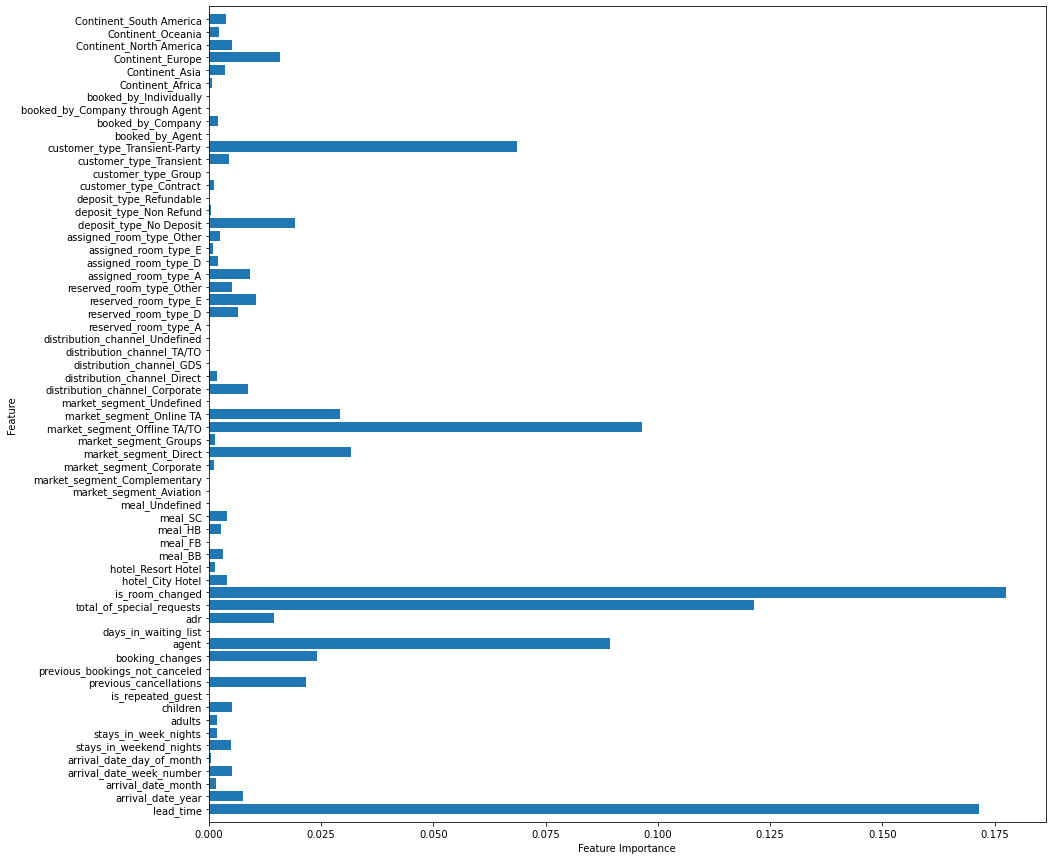

In [61]:
plot_feature_importances(X_train,gridSearch.best_estimator_)

- We have found the best performing decision tree, now lets find for which threshold it is giving optimum resilts

In [62]:
best_decision_tree = DecisionTreeClassifier(max_depth=30,min_impurity_decrease=0.0001,min_samples_split=20,random_state=1)
best_decision_tree.fit(X_train,y_train)
class_perf_measures(best_decision_tree,X_test,y_test,0,1,0.1)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3933,3475,6483,241,27.8324,24.5913,45.8779,1.7055,0.3780,0.9420,0.5200,0.5400,0.6460
2,0.2000,3648,5414,4544,526,25.8156,38.3129,32.1563,3.7223,0.4450,0.8740,0.6400,0.5900,0.7090
3,0.3000,3354,6607,3351,820,23.7351,46.7554,23.7138,5.8028,0.5000,0.8040,0.7000,0.6200,0.7340
4,0.4000,2904,7912,2046,1270,20.5506,55.9904,14.4788,8.9873,0.5870,0.6960,0.7700,0.6400,0.7450
5,0.5000,2621,8406,1552,1553,18.5479,59.4862,10.9829,10.9900,0.6280,0.6280,0.7800,0.6300,0.7360
6,0.6000,2329,8858,1100,1845,16.4815,62.6849,7.7843,13.0564,0.6790,0.5580,0.7900,0.6100,0.7240
7,0.7000,2043,9156,802,2131,14.4576,64.7937,5.6755,15.0803,0.7180,0.4890,0.7900,0.5800,0.7040
8,0.8000,1537,9504,454,2637,10.8768,67.2564,3.2128,18.6611,0.7720,0.3680,0.7800,0.5000,0.6610
9,0.9000,881,9746,212,3293,6.2345,68.9689,1.5002,23.3034,0.8060,0.2110,0.7500,0.3300,0.5950


In [63]:
bestClassTree = gridSearch.best_estimator_
class_perf_measures(bestClassTree,X_test,y_test,0,1,0.1)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3933,3475,6483,241,27.8324,24.5913,45.8779,1.7055,0.3780,0.9420,0.5200,0.5400,0.6460
2,0.2000,3648,5414,4544,526,25.8156,38.3129,32.1563,3.7223,0.4450,0.8740,0.6400,0.5900,0.7090
3,0.3000,3354,6607,3351,820,23.7351,46.7554,23.7138,5.8028,0.5000,0.8040,0.7000,0.6200,0.7340
4,0.4000,2904,7912,2046,1270,20.5506,55.9904,14.4788,8.9873,0.5870,0.6960,0.7700,0.6400,0.7450
5,0.5000,2621,8406,1552,1553,18.5479,59.4862,10.9829,10.9900,0.6280,0.6280,0.7800,0.6300,0.7360
6,0.6000,2329,8858,1100,1845,16.4815,62.6849,7.7843,13.0564,0.6790,0.5580,0.7900,0.6100,0.7240
7,0.7000,2043,9156,802,2131,14.4576,64.7937,5.6755,15.0803,0.7180,0.4890,0.7900,0.5800,0.7040
8,0.8000,1537,9504,454,2637,10.8768,67.2564,3.2128,18.6611,0.7720,0.3680,0.7800,0.5000,0.6610
9,0.9000,881,9746,212,3293,6.2345,68.9689,1.5002,23.3034,0.8060,0.2110,0.7500,0.3300,0.5950


- Here I am chossing threshold of 0.3 by checking AUC, accuracy and recall values.

In [64]:
decision_tree_threshold = 0.3

decision_tree_pred = (bestClassTree.predict_proba(X_test)[:,1] >= decision_tree_threshold).astype(int)

features_used = (gridSearch.best_estimator_.feature_importances_>0).sum()
hyperparameters = bestClassTree.get_params()
model = "Decision tree"
df_results = update_results_df(model,y_test,decision_tree_pred,features_used,total_time,df_results,hyperparameters)

{'ccp_alpha': 0.0, 'max_depth': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}


In [65]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan
4,Ridge for alpha = 100,0.7560,0.6210,0.5820,0.7170,1.1521,1580,1864,52,nan
5,Ridge for alpha = 10 for selected features,0.7400,0.6650,0.5500,0.7180,0.7021,1400,2274,31,nan
6,Decision tree,0.7050,0.8040,0.5000,0.7340,20.3381,820,3351,46,"{'ccp_alpha': 0.0, 'max_depth': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}"


- I did the prooning using max depth, minimum impurity decrease and minimum samples split, now I want to use the cost complexity prooning

In [66]:
path = bestClassTree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
len(ccp_alphas)

164

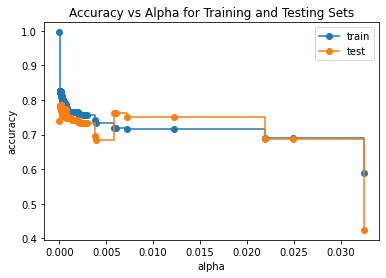

In [67]:
dts = []

for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dt.fit(X_train,y_train)
    dts.append(dt)
    
train_scores = [dt.score(X_train,y_train) for dt in dts]
test_scores = [dt.score(X_test,y_test) for dt in dts]

fix, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title("Accuracy vs Alpha for Training and Testing Sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle='steps-post')
ax.legend()
plt.show()


- After looking at all the 126 it looks like best ccp alpha is in initial 2-3 values so lets plot for first few values only

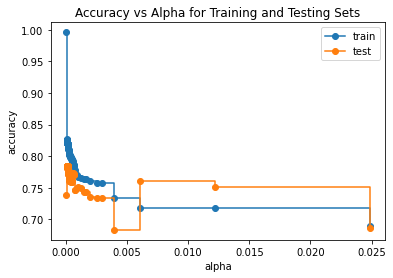

In [68]:
fix, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title("Accuracy vs Alpha for Training and Testing Sets")
ax.plot(ccp_alphas[0::2], train_scores[0::2], marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[0::2], test_scores[0::2], marker='o', label="test",drawstyle='steps-post')
ax.legend()
plt.show()

In [69]:
ccp_alphas

array([0.        , 0.00010003, 0.00010171, 0.00010444, 0.00010448,
       0.00010451, 0.00010456, 0.00010598, 0.00010635, 0.00010763,
       0.00010821, 0.00010893, 0.00010896, 0.00010925, 0.00010974,
       0.00011322, 0.00011368, 0.00011382, 0.00011451, 0.00011549,
       0.00011744, 0.00011803, 0.00011968, 0.00012342, 0.00012453,
       0.00012472, 0.00012474, 0.00012535, 0.0001256 , 0.00012703,
       0.00012721, 0.00012739, 0.00012824, 0.0001285 , 0.00012877,
       0.00012935, 0.00013055, 0.0001323 , 0.00013337, 0.000137  ,
       0.00013819, 0.00014015, 0.00014195, 0.00014329, 0.00014447,
       0.00014495, 0.00014731, 0.00014744, 0.00014856, 0.00014923,
       0.00014925, 0.00015046, 0.00015371, 0.00015413, 0.00015531,
       0.00015754, 0.00015783, 0.00015784, 0.00016065, 0.00016118,
       0.00016147, 0.00016332, 0.00016346, 0.00016388, 0.00016612,
       0.00016623, 0.00016928, 0.0001767 , 0.00017981, 0.00018331,
       0.00018719, 0.00019119, 0.00019423, 0.00019481, 0.00019

- It looks like the accuracy for traina dn test is high for very small alpha values. After looking at the ccp_alphas, I am taking 0.00010153 as my alpha

In [70]:
start_time = time.time()
decision_tree_ccp = DecisionTreeClassifier(random_state=1, ccp_alpha=0.00010153)
decision_tree_ccp.fit(X_train,y_train)
total_time = time.time() - start_time
class_perf_measures(decision_tree_ccp,X_test,y_test,0,1,0.1)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3913,3760,6198,261,27.6909,26.6082,43.8610,1.8470,0.3870,0.9370,0.5400,0.5500,0.6580
2,0.2000,3644,5446,4512,530,25.7873,38.5394,31.9298,3.7506,0.4470,0.8730,0.6400,0.5900,0.7100
3,0.3000,3308,6781,3177,866,23.4095,47.9867,22.4825,6.1284,0.5100,0.7930,0.7100,0.6200,0.7370
4,0.4000,2864,8025,1933,1310,20.2675,56.7900,13.6791,9.2704,0.5970,0.6860,0.7700,0.6400,0.7460
5,0.5000,2635,8417,1541,1539,18.6469,59.5641,10.9051,10.8909,0.6310,0.6310,0.7800,0.6300,0.7380
6,0.6000,2376,8810,1148,1798,16.8141,62.3452,8.1240,12.7238,0.6740,0.5690,0.7900,0.6200,0.7270
7,0.7000,2043,9165,793,2131,14.4576,64.8574,5.6118,15.0803,0.7200,0.4890,0.7900,0.5800,0.7050
8,0.8000,1542,9501,457,2632,10.9122,67.2352,3.2340,18.6257,0.7710,0.3690,0.7800,0.5000,0.6620
9,0.9000,887,9743,215,3287,6.2770,68.9477,1.5215,23.2609,0.8050,0.2130,0.7500,0.3400,0.5950


- choosing threshold of 0.3 by considering AUC, accuracy and recall

In [72]:
decision_tree_ccp_threshold = 0.3

decision_tree_ccp_pred = (decision_tree_ccp.predict_proba(X_test)[:,1] >= decision_tree_ccp_threshold).astype(int)

features_used = (decision_tree_ccp.feature_importances_>0).sum()
hyperparameters = decision_tree_ccp.get_params()

model = "Decision tree Cost Complexity prooning"
df_results = update_results_df(model,y_test,decision_tree_ccp_pred,features_used,total_time,df_results,hyperparameters)
               

{'ccp_alpha': 0.00010153, 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2}


In [73]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan
4,Ridge for alpha = 100,0.7560,0.6210,0.5820,0.7170,1.1521,1580,1864,52,nan
5,Ridge for alpha = 10 for selected features,0.7400,0.6650,0.5500,0.7180,0.7021,1400,2274,31,nan
6,Decision tree,0.7050,0.8040,0.5000,0.7340,20.3381,820,3351,46,"{'ccp_alpha': 0.0, 'max_depth': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}"
7,Decision tree Cost Complexity prooning,0.7140,0.7930,0.5100,0.7370,3.0470,866,3177,48,"{'ccp_alpha': 0.00010153, 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2}"


## 6.5 Random Forest

### 6.5.1 Using all features

- I am using similar hyper parameters that i used in decision tree
- I am also using criterion to calculate the impurity which can be gini or entropy
- Similar to decision tree I am using accuracy, recall and precision as scoring parameters and best estimator is selected based on accuracy

In [74]:
start_time = time.time()
random_forest_2 = RandomForestClassifier(random_state=1)
param_grid = { 
    'max_depth': [15,20],
    'min_samples_split': [20],
    'min_impurity_decrease': [0, 0.0001],
    'criterion' :['gini', 'entropy'],
    'ccp_alpha' : [ 0.00010131, 0.00010153]
}
random_forest_grid_search_2 = GridSearchCV(estimator=random_forest_2, param_grid=param_grid, cv= 5,scoring=['accuracy','recall','precision','roc_auc'], refit='roc_auc')
random_forest_grid_search_2.fit(X_train, y_train)

best_random_forest_2 = random_forest_grid_search_2.best_estimator_
total_time = time.time() - start_time

class_perf_measures(best_random_forest_2,X_test,y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,4107,1925,8033,67,29.0638,13.6225,56.8466,0.4741,0.3380,0.9840,0.4300,0.5000,0.5890
2,0.2000,3888,4649,5309,286,27.5140,32.8993,37.5699,2.0239,0.4230,0.9310,0.6000,0.5800,0.6990
3,0.3000,3605,6075,3883,569,25.5113,42.9906,27.4786,4.0266,0.4810,0.8640,0.6800,0.6200,0.7370
4,0.4000,3251,7313,2645,923,23.0062,51.7515,18.7177,6.5317,0.5510,0.7790,0.7500,0.6500,0.7570
5,0.5000,2747,8451,1507,1427,19.4395,59.8047,10.6645,10.0984,0.6460,0.6580,0.7900,0.6500,0.7530
6,0.6000,2199,9140,818,1975,15.5615,64.6805,5.7887,13.9764,0.7290,0.5270,0.8000,0.6100,0.7220
7,0.7000,1709,9432,526,2465,12.0940,66.7469,3.7223,17.4439,0.7650,0.4090,0.7900,0.5300,0.6780
8,0.8000,1153,9713,245,3021,8.1594,68.7354,1.7338,21.3785,0.8250,0.2760,0.7700,0.4100,0.6260
9,0.9000,176,9956,2,3998,1.2455,70.4550,0.0142,28.2924,0.9890,0.0420,0.7200,0.0800,0.5210


In [75]:
class_perf_measures(best_random_forest_2,X_test,y_test,0.3,0.4,0.01)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.3000,3605,6075,3883,569,25.5113,42.9906,27.4786,4.0266,0.4810,0.8640,0.6800,0.6200,0.7370
1,0.3100,3579,6201,3757,595,25.3273,43.8822,26.5869,4.2106,0.4880,0.8570,0.6900,0.6200,0.7400
2,0.3200,3555,6313,3645,619,25.1575,44.6748,25.7944,4.3804,0.4940,0.8520,0.7000,0.6300,0.7430
3,0.3300,3522,6421,3537,652,24.9239,45.4391,25.0301,4.6140,0.4990,0.8440,0.7000,0.6300,0.7440
4,0.3400,3491,6536,3422,683,24.7046,46.2529,24.2163,4.8333,0.5050,0.8360,0.7100,0.6300,0.7460
5,0.3500,3461,6656,3302,713,24.4923,47.1021,23.3671,5.0456,0.5120,0.8290,0.7200,0.6300,0.7490
6,0.3600,3420,6776,3182,754,24.2021,47.9513,22.5179,5.3358,0.5180,0.8190,0.7200,0.6300,0.7500
7,0.3700,3382,6921,3037,792,23.9332,48.9774,21.4918,5.6047,0.5270,0.8100,0.7300,0.6400,0.7530
8,0.3800,3344,7047,2911,830,23.6643,49.8691,20.6001,5.8736,0.5350,0.8010,0.7400,0.6400,0.7540
9,0.3900,3300,7179,2779,874,23.3529,50.8032,19.6660,6.1850,0.5430,0.7910,0.7400,0.6400,0.7560


In [76]:
rondom_forest_threshold_2 = 0.31

random_forest_pred_2 = (best_random_forest_2.predict_proba(X_test)[:,1] >= rondom_forest_threshold_2).astype(int)

features_used = (best_random_forest_2.feature_importances_>0).sum()
hyperparameters = best_random_forest_2.get_params()

model = "Random Forest"
df_results = update_results_df(model,y_test,random_forest_pred_2,features_used,total_time,df_results,hyperparameters)


{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [77]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan
4,Ridge for alpha = 100,0.7560,0.6210,0.5820,0.7170,1.1521,1580,1864,52,nan
5,Ridge for alpha = 10 for selected features,0.7400,0.6650,0.5500,0.7180,0.7021,1400,2274,31,nan
6,Decision tree,0.7050,0.8040,0.5000,0.7340,20.3381,820,3351,46,"{'ccp_alpha': 0.0, 'max_depth': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}"
7,Decision tree Cost Complexity prooning,0.7140,0.7930,0.5100,0.7370,3.0470,866,3177,48,"{'ccp_alpha': 0.00010153, 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2}"
8,Random Forest,0.6920,0.8570,0.4880,0.7400,1169.1351,595,3757,63,"{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}"


### 6.5.2 Using selected features

In [78]:
start_time = time.time()
random_forest_3 = RandomForestClassifier(random_state=1)
param_grid = { 
    'max_depth': [15,20],
    'min_samples_split': [20],
    'min_impurity_decrease': [0, 0.0001],
    'criterion' :['gini', 'entropy'],
    'ccp_alpha' : [ 0.00010131, 0.00010153]
}
random_forest_grid_search_3 = GridSearchCV(estimator=random_forest_3, param_grid=param_grid, cv= 5,scoring=['accuracy','recall','precision','roc_auc'],
                          refit='roc_auc')
random_forest_grid_search_3.fit(X_train[param], y_train)

best_random_forest_3 = random_forest_grid_search_3.best_estimator_
total_time = time.time() - start_time

class_perf_measures(best_random_forest_3,X_test[param],y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,4073,2569,7389,101,28.8232,18.1799,52.2893,0.7147,0.3550,0.9760,0.4700,0.5200,0.6170
2,0.2000,3844,4852,5106,330,27.2026,34.3359,36.1333,2.3353,0.4290,0.9210,0.6200,0.5900,0.7040
3,0.3000,3611,6035,3923,563,25.5537,42.7075,27.7617,3.9841,0.4790,0.8650,0.6800,0.6200,0.7360
4,0.4000,3297,7194,2764,877,23.3317,50.9093,19.5598,6.2062,0.5440,0.7900,0.7400,0.6400,0.7560
5,0.5000,2878,8211,1747,1296,20.3666,58.1063,12.3629,9.1713,0.6220,0.6900,0.7800,0.6500,0.7570
6,0.6000,2327,8967,991,1847,16.4673,63.4562,7.0130,13.0706,0.7010,0.5570,0.8000,0.6200,0.7290
7,0.7000,1852,9393,565,2322,13.1059,66.4709,3.9983,16.4320,0.7660,0.4440,0.8000,0.5600,0.6930
8,0.8000,1440,9594,364,2734,10.1904,67.8933,2.5759,19.3475,0.7980,0.3450,0.7800,0.4800,0.6540
9,0.9000,399,9939,19,3775,2.8236,70.3347,0.1345,26.7143,0.9550,0.0960,0.7300,0.1700,0.5470


In [113]:
class_perf_measures(best_random_forest_3,X_test[param],y_test,0.3,0.5,0.01)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.3000,3611,6035,3923,563,25.5537,42.7075,27.7617,3.9841,0.4790,0.8650,0.6800,0.6200,0.7360
1,0.3100,3591,6162,3796,583,25.4122,43.6063,26.8629,4.1257,0.4860,0.8600,0.6900,0.6200,0.7400
2,0.3200,3562,6262,3696,612,25.2070,44.3139,26.1553,4.3309,0.4910,0.8530,0.7000,0.6200,0.7410
3,0.3300,3523,6381,3577,651,24.9310,45.1560,25.3131,4.6069,0.4960,0.8440,0.7000,0.6200,0.7420
4,0.3400,3495,6498,3460,679,24.7329,45.9840,24.4852,4.8050,0.5030,0.8370,0.7100,0.6300,0.7450
5,0.3500,3467,6605,3353,707,24.5347,46.7412,23.7280,5.0032,0.5080,0.8310,0.7100,0.6300,0.7470
6,0.3600,3431,6715,3243,743,24.2800,47.5196,22.9495,5.2579,0.5140,0.8220,0.7200,0.6300,0.7480
7,0.3700,3398,6824,3134,776,24.0464,48.2910,22.1782,5.4915,0.5200,0.8140,0.7200,0.6300,0.7500
8,0.3800,3362,6945,3013,812,23.7917,49.1473,21.3219,5.7462,0.5270,0.8050,0.7300,0.6400,0.7510
9,0.3900,3328,7073,2885,846,23.5511,50.0531,20.4161,5.9868,0.5360,0.7970,0.7400,0.6400,0.7540


In [114]:
random_forest_threshold_3 = 0.47

random_forest_pred_3 = (best_random_forest_3.predict_proba(X_test[param])[:,1] >= random_forest_threshold_3).astype(int)

features_used = (best_random_forest_3.feature_importances_>0).sum()
hyperparameters = best_random_forest_3.get_params()

model = "Random Forest using selected features"
df_results = update_results_df(model,y_test,random_forest_pred_3,features_used,total_time,df_results,hyperparameters)

{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}


**Observations**

- All the performance parameters are exactly same for both the random forest models 
- Features used in 2nd model are almost half of the first model
- Comparing the random forest with other models, accuracy of the random forest is good bur recall is less than decision tree
- Time taken for random forest is very high compared to other models maybe except lasso regularization model

In [81]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan
4,Ridge for alpha = 100,0.7560,0.6210,0.5820,0.7170,1.1521,1580,1864,52,nan
5,Ridge for alpha = 10 for selected features,0.7400,0.6650,0.5500,0.7180,0.7021,1400,2274,31,nan
6,Decision tree,0.7050,0.8040,0.5000,0.7340,20.3381,820,3351,46,"{'ccp_alpha': 0.0, 'max_depth': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}"
7,Decision tree Cost Complexity prooning,0.7140,0.7930,0.5100,0.7370,3.0470,866,3177,48,"{'ccp_alpha': 0.00010153, 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2}"
8,Random Forest,0.6920,0.8570,0.4880,0.7400,1169.1351,595,3757,63,"{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}"
9,Random Forest using selected features,0.6770,0.8720,0.4750,0.7340,918.7125,535,4028,34,"{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}"


In [82]:
start_time = time.time()
random_forest_4 = RandomForestClassifier(random_state=1)
param_grid = { 
    'max_depth': np.arange(1,100,3)
}
random_forest_grid_search_4 = GridSearchCV(estimator=random_forest_4, param_grid=param_grid, cv= 5,scoring=['accuracy','recall','precision','roc_auc'],
                          refit='roc_auc')
random_forest_grid_search_4.fit(X_train[param], y_train)

best_random_forest_4 = random_forest_grid_search_4.best_estimator_
total_time = time.time() - start_time

class_perf_measures(best_random_forest_4,X_test[param],y_test,0,1,0.1)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3928,4198,5760,246,27.7970,29.7077,40.7614,1.7409,0.4050,0.9410,0.5800,0.5700,0.6810
2,0.2000,3692,5860,4098,482,26.1270,41.4691,29.0001,3.4109,0.4740,0.8850,0.6800,0.6200,0.7360
3,0.3000,3425,6960,2998,749,24.2375,49.2534,21.2158,5.3004,0.5330,0.8210,0.7300,0.6500,0.7600
4,0.4000,3125,7763,2195,1049,22.1145,54.9360,15.5332,7.4234,0.5870,0.7490,0.7700,0.6600,0.7640
5,0.5000,2805,8404,1554,1369,19.8500,59.4721,10.9971,9.6879,0.6430,0.6720,0.7900,0.6600,0.7580
6,0.6000,2431,8898,1060,1743,17.2033,62.9679,7.5012,12.3346,0.6960,0.5820,0.8000,0.6300,0.7380
7,0.7000,2081,9267,691,2093,14.7265,65.5792,4.8900,14.8114,0.7510,0.4990,0.8000,0.6000,0.7150
8,0.8000,1595,9565,393,2579,11.2872,67.6881,2.7811,18.2507,0.8020,0.3820,0.7900,0.5200,0.6710
9,0.9000,968,9826,132,3206,6.8502,69.5351,0.9341,22.6877,0.8800,0.2320,0.7600,0.3700,0.6090


In [83]:
class_perf_measures(best_random_forest_4,X_test[param],y_test,0.2,0.3,0.01)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.2000,3692,5860,4098,482,26.1270,41.4691,29.0001,3.4109,0.4740,0.8850,0.6800,0.6200,0.7360
1,0.2100,3655,6039,3919,519,25.8651,42.7358,27.7334,3.6728,0.4830,0.8760,0.6900,0.6200,0.7410
2,0.2200,3634,6172,3786,540,25.7165,43.6770,26.7922,3.8214,0.4900,0.8710,0.6900,0.6300,0.7450
3,0.2300,3607,6282,3676,567,25.5254,44.4555,26.0137,4.0125,0.4950,0.8640,0.7000,0.6300,0.7480
4,0.2400,3587,6398,3560,587,25.3839,45.2763,25.1928,4.1540,0.5020,0.8590,0.7100,0.6300,0.7510
5,0.2500,3566,6497,3461,608,25.2353,45.9769,24.4923,4.3026,0.5070,0.8540,0.7100,0.6400,0.7530
6,0.2600,3545,6613,3345,629,25.0867,46.7978,23.6714,4.4512,0.5150,0.8490,0.7200,0.6400,0.7570
7,0.2700,3519,6701,3257,655,24.9027,47.4206,23.0486,4.6352,0.5190,0.8430,0.7200,0.6400,0.7580
8,0.2800,3472,6814,3144,702,24.5701,48.2202,22.2490,4.9678,0.5250,0.8320,0.7300,0.6400,0.7580
9,0.2900,3450,6888,3070,724,24.4144,48.7439,21.7253,5.1235,0.5290,0.8270,0.7300,0.6500,0.7590


In [84]:
random_forest_threshold_4 = 0.29

random_forest_pred_4 = (best_random_forest_4.predict_proba(X_test[param])[:,1] >= random_forest_threshold_3).astype(int)

features_used = (best_random_forest_4.feature_importances_>0).sum()
hyperparameters = best_random_forest_4.get_params()

model = "Random Forest using selected features"
df_results = update_results_df(model,y_test,random_forest_pred_4,features_used,total_time,df_results,hyperparameters)

{'ccp_alpha': 0.0, 'max_depth': 31, 'min_impurity_decrease': 0.0, 'min_samples_split': 2}


## 6.6 XGBoost

### 6.6.1 Using all the features

- Using XGBClassifier with objective as binary logistic model
- Using max_depth, alpha and lambda values used in decision tree, Ridge and Lasso Regularization 
- learning is how fast your model learns. If the learning rate is high then weight for first models is more than lst models where as if learning rate is low then weights are similar
- I am using range of learning rates to find the best one

In [85]:
start_time = time.time()
for rate in [0.1,0.5,0.75,0.9]:
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=30,learning_rate=rate,reg_alpha=100,reg_lambda=100)
    xgb_model.fit(X_train, y_train)

    xgb_pred = xgb_model.predict(X_test)
total_time = time.time() - start_time

- After looking at all the models with different leaning rate, it is evident that accuracy and recall is better for rate = 0.75
- So I will add that model results in df_results

In [86]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=30,learning_rate=0.75,reg_alpha=100,reg_lambda=100)
xgb_model.fit(X_train, y_train)
class_perf_measures(xgb_model,X_test,y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3992,3496,6462,182,28.2499,24.7399,45.7292,1.2879,0.3820,0.9560,0.5300,0.5500,0.6540
2,0.2000,3690,5755,4203,484,26.1128,40.7261,29.7431,3.4251,0.4680,0.8840,0.6700,0.6100,0.7310
3,0.3000,3349,7087,2871,825,23.6997,50.1521,20.3170,5.8382,0.5380,0.8020,0.7400,0.6400,0.7570
4,0.4000,3017,8017,1941,1157,21.3502,56.7334,13.7358,8.1877,0.6090,0.7230,0.7800,0.6600,0.7640
5,0.5000,2637,8675,1283,1537,18.6611,61.3899,9.0793,10.8768,0.6730,0.6320,0.8000,0.6500,0.7510
6,0.6000,2275,9072,886,1899,16.0994,64.1993,6.2699,13.4385,0.7200,0.5450,0.8000,0.6200,0.7280
7,0.7000,1851,9404,554,2323,13.0989,66.5487,3.9205,16.4390,0.7700,0.4430,0.8000,0.5600,0.6940
8,0.8000,1370,9660,298,2804,9.6950,68.3603,2.1088,19.8429,0.8210,0.3280,0.7800,0.4700,0.6490
9,0.9000,599,9880,78,3575,4.2389,69.9172,0.5520,25.2990,0.8850,0.1440,0.7400,0.2500,0.5680


In [87]:
class_perf_measures(xgb_model,X_test,y_test,0.3,0.4,0.01)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.3000,3349,7087,2871,825,23.6997,50.1521,20.3170,5.8382,0.5380,0.8020,0.7400,0.6400,0.7570
1,0.3100,3314,7195,2763,860,23.4520,50.9164,19.5528,6.0859,0.5450,0.7940,0.7400,0.6500,0.7580
2,0.3200,3282,7296,2662,892,23.2255,51.6312,18.8380,6.3124,0.5520,0.7860,0.7500,0.6500,0.7590
3,0.3300,3244,7387,2571,930,22.9566,52.2751,18.1940,6.5813,0.5580,0.7770,0.7500,0.6500,0.7600
4,0.3400,3206,7490,2468,968,22.6877,53.0040,17.4651,6.8502,0.5650,0.7680,0.7600,0.6500,0.7600
5,0.3500,3185,7581,2377,989,22.5391,53.6480,16.8212,6.9988,0.5730,0.7630,0.7600,0.6500,0.7620
6,0.3600,3150,7674,2284,1024,22.2914,54.3061,16.1630,7.2465,0.5800,0.7550,0.7700,0.6600,0.7630
7,0.3700,3108,7767,2191,1066,21.9942,54.9643,15.5049,7.5437,0.5870,0.7450,0.7700,0.6600,0.7620
8,0.3800,3073,7848,2110,1101,21.7465,55.5375,14.9317,7.7914,0.5930,0.7360,0.7700,0.6600,0.7620
9,0.3900,3045,7932,2026,1129,21.5484,56.1319,14.3373,7.9895,0.6000,0.7300,0.7800,0.6600,0.7630


- Here i am selecting threshold of 0.34

In [88]:
xgboost_threshold = 0.34

xgb_pred = (xgb_model.predict_proba(X_test)[:,1] >= xgboost_threshold).astype(int)

features_used = (xgb_model.feature_importances_>0).sum()
hyperparameters = {"max_depth": 30, "learning_rate":0.75}

model = "XG Boost"
df_results = update_results_df(model,y_test,xgb_pred,features_used,total_time,df_results,hyperparameters)

{'max_depth': 30, 'learning_rate': 0.75}


In [89]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan
4,Ridge for alpha = 100,0.7560,0.6210,0.5820,0.7170,1.1521,1580,1864,52,nan
5,Ridge for alpha = 10 for selected features,0.7400,0.6650,0.5500,0.7180,0.7021,1400,2274,31,nan
6,Decision tree,0.7050,0.8040,0.5000,0.7340,20.3381,820,3351,46,"{'ccp_alpha': 0.0, 'max_depth': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}"
7,Decision tree Cost Complexity prooning,0.7140,0.7930,0.5100,0.7370,3.0470,866,3177,48,"{'ccp_alpha': 0.00010153, 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2}"
8,Random Forest,0.6920,0.8570,0.4880,0.7400,1169.1351,595,3757,63,"{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}"
9,Random Forest using selected features,0.6770,0.8720,0.4750,0.7340,918.7125,535,4028,34,"{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}"


### 6.6.2 Using selected features

In [90]:
start_time = time.time()
for rate in [0.1,0.5,0.75,0.9]:
    xgb_model_2 = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=20,learning_rate=rate,reg_alpha=100,reg_lambda=100)
    xgb_model_2.fit(X_train[param], y_train)

    y_pred = xgb_model_2.predict(X_test[param])
total_time = time.time() - start_time

- Similar to the last model, in this model also learning rate of 0.75 is performing the best
- I will add the performance of that model in df_results

In [91]:
xgb_model_2 = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=20,learning_rate=0.75,reg_alpha=100,reg_lambda=100)
xgb_model_2.fit(X_train[param], y_train)
class_perf_measures(xgb_model_2,X_test[param],y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,4005,3110,6848,169,28.3419,22.0084,48.4608,1.1960,0.3690,0.9600,0.5000,0.5300,0.6360
2,0.2000,3753,5326,4632,421,26.5586,37.6902,32.7790,2.9793,0.4480,0.8990,0.6400,0.6000,0.7170
3,0.3000,3485,6634,3324,689,24.6621,46.9464,23.5228,4.8758,0.5120,0.8350,0.7200,0.6300,0.7510
4,0.4000,3153,7661,2297,1021,22.3126,54.2141,16.2550,7.2252,0.5790,0.7550,0.7700,0.6600,0.7620
5,0.5000,2778,8364,1594,1396,19.6589,59.1890,11.2802,9.8790,0.6350,0.6660,0.7900,0.6500,0.7530
6,0.6000,2416,8883,1075,1758,17.0972,62.8618,7.6074,12.4407,0.6920,0.5790,0.8000,0.6300,0.7350
7,0.7000,2038,9241,717,2136,14.4222,65.3952,5.0740,15.1157,0.7400,0.4880,0.8000,0.5900,0.7080
8,0.8000,1585,9526,432,2589,11.2165,67.4121,3.0571,18.3214,0.7860,0.3800,0.7900,0.5100,0.6680
9,0.9000,770,9842,116,3404,5.4490,69.6483,0.8209,24.0889,0.8690,0.1840,0.7500,0.3000,0.5860


In [92]:
class_perf_measures(xgb_model_2,X_test[param],y_test,0.3,0.5,0.01)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.3000,3485,6634,3324,689,24.6621,46.9464,23.5228,4.8758,0.5120,0.8350,0.7200,0.6300,0.7510
1,0.3100,3455,6752,3206,719,24.4498,47.7815,22.6877,5.0881,0.5190,0.8280,0.7200,0.6400,0.7530
2,0.3200,3422,6873,3085,752,24.2163,48.6377,21.8314,5.3216,0.5260,0.8200,0.7300,0.6400,0.7550
3,0.3300,3386,6987,2971,788,23.9615,49.4445,21.0247,5.5764,0.5330,0.8110,0.7300,0.6400,0.7560
4,0.3400,3356,7093,2865,818,23.7492,50.1946,20.2746,5.7887,0.5390,0.8040,0.7400,0.6500,0.7580
5,0.3500,3318,7189,2769,856,23.4803,50.8740,19.5952,6.0576,0.5450,0.7950,0.7400,0.6500,0.7580
6,0.3600,3285,7277,2681,889,23.2468,51.4967,18.9725,6.2911,0.5510,0.7870,0.7500,0.6500,0.7590
7,0.3700,3257,7367,2591,917,23.0486,52.1336,18.3356,6.4893,0.5570,0.7800,0.7500,0.6500,0.7600
8,0.3800,3219,7458,2500,955,22.7797,52.7776,17.6916,6.7582,0.5630,0.7710,0.7600,0.6500,0.7600
9,0.3900,3192,7561,2397,982,22.5886,53.5065,16.9627,6.9493,0.5710,0.7650,0.7600,0.6500,0.7620


- Here I am considering th = 0.38

In [93]:
xgboost_threshold_2 = 0.38

xgb_pred_2 = (xgb_model_2.predict_proba(X_test[param])[:,1] >= xgboost_threshold_2).astype(int)

features_used = (xgb_model_2.feature_importances_>0).sum()
hyperparameters = {"max_depth": 20, "learning_rate":0.75}

model = "XG Boost with selected features"
df_results = update_results_df(model,y_test,xgb_pred_2,features_used,total_time,df_results,hyperparameters)

{'max_depth': 20, 'learning_rate': 0.75}


## 6.7 Artifical Neral Network

### 6.7.1 Using all features

- In the first model I am using only 2 hidden layers as i want to keep it simple and small
- Activation function used is relu as is the most common activation function. I will try other functions later

In [94]:
nural_net = MLPClassifier(hidden_layer_sizes=[35, 20], alpha=0.001, solver='adam', activation='relu',random_state=1)
nural_net.fit(X_train_std, y_train)
nural_net_pred = nural_net.predict(X_test_std)

print("Accuracy for model 1: ",round(accuracy_score(y_test, nural_net_pred),3))
print("Recall for model 1: ",round(recall_score(y_test, nural_net_pred),3))
print("Precision for model 1: ",round(precision_score(y_test, nural_net_pred),3))

Accuracy for model 1:  0.786
Recall for model 1:  0.634
Precision for model 1:  0.639


- For the second model, I am increasing the size to get higher accuracy 

In [95]:
nural_net_2 = MLPClassifier(hidden_layer_sizes=[35, 20, 20, 20], alpha=0.001, solver='adam', activation='relu',random_state=1)
nural_net_2.fit(X_train_std, y_train)
nural_net_pred_2 = nural_net_2.predict(X_test_std)

print("Accuracy for model 2: ",round(accuracy_score(y_test, nural_net_pred_2),3))
print("Recall for model 2: ",round(recall_score(y_test, nural_net_pred_2),3))
print("Precision for model 2: ",round(precision_score(y_test, nural_net_pred_2),3))

Accuracy for model 2:  0.771
Recall for model 2:  0.652
Precision for model 2:  0.604


- Now that I have ran couple of models, I want to try using different hyperparameters
- I am using gridsercg to create 3 models with hidden layers size: (50,50,50),(50,100,50),(100) with cv=5 
- I will be selecting best model based on AUC

In [96]:
start_time = time.time()
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy','recall':'recall','precision':'precision'}
grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)]}
ANNGrid = GridSearchCV(estimator=MLPClassifier(random_state=1021),cv=5,scoring=scoring, refit='AUC',param_grid=grid)
ANNGrid_results = ANNGrid.fit(X_train_std, y_train).cv_results_
ANNGridresults=pd.DataFrame(ANNGrid_results)
total_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural

--- 5293.370942831039 seconds ---


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [97]:
ANNGridresults[['param_hidden_layer_sizes','params','mean_test_Accuracy','mean_test_AUC','rank_test_AUC','mean_test_recall','mean_test_precision']]

,param_hidden_layer_sizes,params,mean_test_Accuracy,mean_test_AUC,rank_test_AUC,mean_test_recall,mean_test_precision
0,"(50, 50, 50)","{'hidden_layer_sizes': (50, 50, 50)}",0.8127,0.9007,2,0.8048,0.8155
1,"(50, 100, 50)","{'hidden_layer_sizes': (50, 100, 50)}",0.8071,0.8963,3,0.8058,0.8064
2,"(100,)","{'hidden_layer_sizes': (100,)}",0.8235,0.9118,1,0.7935,0.8421


In [98]:
best_neural_net = ANNGrid.best_estimator_
class_perf_measures(best_neural_net,X_test_std,y_test,0.2,0.3,0.01)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.2000,3619,5658,4300,555,25.6104,40.0396,30.4296,3.9275,0.4570,0.8670,0.6600,0.6000,0.7180
1,0.2100,3593,5794,4164,581,25.4264,41.0021,29.4671,4.1115,0.4630,0.8610,0.6600,0.6000,0.7210
2,0.2200,3571,5917,4041,603,25.2707,41.8725,28.5967,4.2672,0.4690,0.8560,0.6700,0.6100,0.7250
3,0.2300,3541,6031,3927,633,25.0584,42.6792,27.7900,4.4795,0.4740,0.8480,0.6800,0.6100,0.7270
4,0.2400,3524,6136,3822,650,24.9381,43.4223,27.0469,4.5998,0.4800,0.8440,0.6800,0.6100,0.7300
5,0.2500,3494,6234,3724,680,24.7258,44.1158,26.3534,4.8121,0.4840,0.8370,0.6900,0.6100,0.7320
6,0.2600,3469,6343,3615,705,24.5489,44.8871,25.5821,4.9890,0.4900,0.8310,0.6900,0.6200,0.7340
7,0.2700,3434,6448,3510,740,24.3012,45.6302,24.8390,5.2367,0.4950,0.8230,0.7000,0.6200,0.7350
8,0.2800,3405,6554,3404,769,24.0960,46.3803,24.0889,5.4419,0.5000,0.8160,0.7000,0.6200,0.7370
9,0.2900,3383,6634,3324,791,23.9403,46.9464,23.5228,5.5976,0.5040,0.8100,0.7100,0.6200,0.7380


- From the grid search we found the model with 100, hidden layers gives the highest AUC
- For that model we checked performance by varying the threshold and found that 0.22 threshold is giving the best combination of recall and accuracy.
- I will now add this model results in df_results

In [106]:
ann_threshold = 0.22

ann_pred = (best_neural_net.predict_proba(X_test_std)[:,1] >= ann_threshold).astype(int)

features_used = len(X_train_std[0])
hyperparameters = best_neural_net.get_params()

model = "Artifical Neural Nets"
df_results = update_results_df(model,y_test,ann_pred,features_used,total_time,df_results,hyperparameters)

{'activation': 'relu', 'hidden_layer_sizes': (100,)}


### 6.7.2 Using selected features

- Hyperparameter tuning took considerable amount of time to create all the models
- Most of the models with activation function as tanh were performing better than relu
- Thus to reduce the time ill be using only tanh as activation function 

In [107]:
start_time = time.time()
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy','recall':'recall','precision':'precision'}
grid = {'hidden_layer_sizes': [(35,25,30,25),(35,25,20,25),(25,35,30,25), (25,35,20,25)]}
ANNGrid_2 = GridSearchCV(estimator=MLPClassifier(random_state=1021),cv=5,scoring=scoring, refit='AUC',param_grid=grid)
ANNGrid_results_2 = ANNGrid_2.fit(X_train_std_small, y_train).cv_results_
ANNGridresults_2=pd.DataFrame(ANNGrid_results_2)
total_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural

--- 13244.655415534973 seconds ---


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [108]:
ANNGridresults_2[['param_hidden_layer_sizes','params','mean_test_Accuracy','mean_test_AUC','rank_test_AUC','mean_test_recall','mean_test_precision']]

,param_hidden_layer_sizes,params,mean_test_Accuracy,mean_test_AUC,rank_test_AUC,mean_test_recall,mean_test_precision
0,"(35, 25, 30, 25)","{'hidden_layer_sizes': (35, 25, 30, 25)}",0.8109,0.8958,2,0.8021,0.8150
1,"(35, 25, 20, 25)","{'hidden_layer_sizes': (35, 25, 20, 25)}",0.8103,0.8969,1,0.8020,0.8144
2,"(25, 35, 30, 25)","{'hidden_layer_sizes': (25, 35, 30, 25)}",0.8080,0.8946,4,0.7898,0.8185
3,"(25, 35, 20, 25)","{'hidden_layer_sizes': (25, 35, 20, 25)}",0.8066,0.8954,3,0.7776,0.8249


In [109]:
best_neural_net_2 = ANNGrid_2.best_estimator_
class_perf_measures(best_neural_net_2,X_test_std_small,y_test,0,1,0.1)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1,AUC
0,0.0000,4174,0,9958,0,29.5379,0.0000,70.4692,0.0000,0.2950,1.0000,0.3000,0.4600,0.5000
1,0.1000,3893,4172,5786,281,27.5494,29.5237,40.9454,1.9885,0.4020,0.9330,0.5700,0.5600,0.6760
2,0.2000,3578,5838,4120,596,25.3202,41.3134,29.1558,4.2177,0.4650,0.8570,0.6700,0.6000,0.7220
3,0.3000,3319,6955,3003,855,23.4874,49.2180,21.2511,6.0505,0.5250,0.7950,0.7300,0.6300,0.7470
4,0.4000,3022,7713,2245,1152,21.3856,54.5821,15.8871,8.1523,0.5740,0.7240,0.7600,0.6400,0.7490
5,0.5000,2672,8369,1589,1502,18.9088,59.2244,11.2448,10.6291,0.6270,0.6400,0.7800,0.6300,0.7400
6,0.6000,2326,8872,1086,1848,16.4603,62.7840,7.6852,13.0776,0.6820,0.5570,0.7900,0.6100,0.7240
7,0.7000,1916,9273,685,2258,13.5588,65.6217,4.8475,15.9791,0.7370,0.4590,0.7900,0.5700,0.6950
8,0.8000,1425,9584,374,2749,10.0842,67.8225,2.6467,19.4537,0.7920,0.3410,0.7800,0.4800,0.6520
9,0.9000,836,9840,118,3338,5.9161,69.6341,0.8350,23.6218,0.8760,0.2000,0.7600,0.3300,0.5940


In [110]:
ann_threshold_2 = 0.29

ann_pred_2 = (best_neural_net_2.predict_proba(X_test_std_small)[:,1] >= ann_threshold_2).astype(int)

features_used = len(X_train_std_small[0])
hyperparameters = best_neural_net_2.get_params()

model = "Artifical Neural Nets with selected features"
df_results = update_results_df(model,y_test,ann_pred_2,features_used,total_time,df_results,hyperparameters)

{'activation': 'relu', 'hidden_layer_sizes': (35, 25, 20, 25)}


In [121]:
df_results

,Model,Accuracy,Recall,Precision,AUC,Total time taken,False Negative,False Positive,Features Used,Hyperparameters
0,Logistic Regression,0.7630,0.6010,0.5980,0.7160,16.1759,1665,1684,62,nan
1,Logistic Regression for selected features,0.6420,0.8250,0.4430,0.6950,4.6143,731,4324,33,nan
2,Lasso for alpha = 100,0.7600,0.6150,0.5900,0.7180,8236.5500,1609,1783,53,nan
3,Lasso for alpha = 10 for selected features,0.6410,0.8270,0.4420,0.6950,867.5720,724,4352,32,nan
4,Ridge for alpha = 100,0.7560,0.6210,0.5820,0.7170,1.1521,1580,1864,52,nan
5,Ridge for alpha = 10 for selected features,0.7400,0.6650,0.5500,0.7180,0.7021,1400,2274,31,nan
6,Decision tree,0.7050,0.8040,0.5000,0.7340,20.3381,820,3351,46,"{'ccp_alpha': 0.0, 'max_depth': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}"
7,Decision tree Cost Complexity prooning,0.7140,0.7930,0.5100,0.7370,3.0470,866,3177,48,"{'ccp_alpha': 0.00010153, 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2}"
8,Random Forest,0.6920,0.8570,0.4880,0.7400,1169.1351,595,3757,63,"{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}"
9,Random Forest using selected features,0.6770,0.8720,0.4750,0.7340,918.7125,535,4028,34,"{'ccp_alpha': 0.00010131, 'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}"


# 7 Conclusion

**Observations**
>- Logistic models are not performing well. They are giving high false negative values if the threshold is 0.5 and if it is changed to 0.3 then false neegatives are reduced but accuracy is also reduced significantly.
>- Lasso Regularization is taking lot of time for building a model
>- Decision trees are fast, accurate and also good recall as well as good AUC
>- Decision tress are reducing the feture number to 2/3rd of total features
>- Cost complexity pruning is giving even better results
>- Random forest is giving high recall but accuracy is slightly less compared to decision trees 
>- Features used as well as time taken for modeling is more for random forest than decision tree
>- Decision tree is clearly better in this case than random forest
>- XGBoost has the highest accuracy and good recall as well as good AUC with comparitively less time
>- Neural Nets gives the best recall but accuracy is limited with high time taken to train the model
>- Neural net take the largest amount of time 

**Conclusion**
>- Considering the amount of features used and time required to built the model, XG Boost with selected features is the best model
>- If high amount of computing power is available then we can go for neural nets as it is giving better recall
>- Approximately 7% of the time model will predict guest will not cancel the bookin but in fact guest will cancel the booking.
>- Similarly 15 % of the time model will predict booking will be cancelled but in reality it will not be cancelled

# 8 Recommendations

>- Most of the features available dont have correlation with booking cancelation. Model might generate considerable false negatives which will result in rooms being empty. This problem will be solved if hotel has high walk in customers 
>- Employer can provide information about walk in guest booking. If number of walk in customers is considerable then employer can choose model which is performing better in accuracy but not that good for recall as walk in guests will can always fill the rooms that get empty last minute
>- Employer can collect feedback from guests who cancel the booking to understand the reason. From those reasons employer migh get more insights regarding what type of data might be useful in the prediction
>- Employer can stop collecting the data which is not required to reduce the cost 